In [1]:
import os
import re
import math
import typing
import warnings
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from scipy.stats import zscore
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split, RandomizedSearchCV

from sklearn.exceptions import DataConversionWarning
from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [2]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning
)

warnings.filterwarnings(
    action='ignore', 
    category=DataConversionWarning
)

np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [4]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Loading Data

In [5]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv', index_col=0)

<AxesSubplot:>

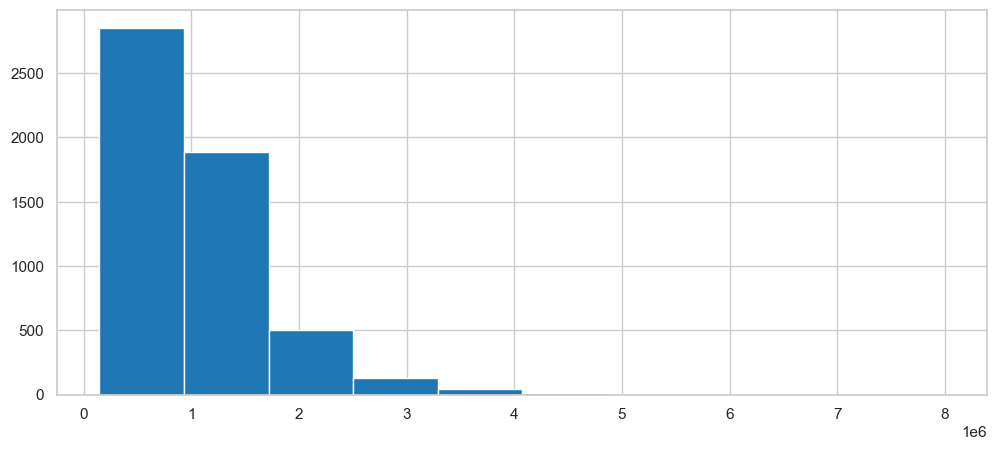

In [6]:
train_set.Price.hist()

<AxesSubplot:>

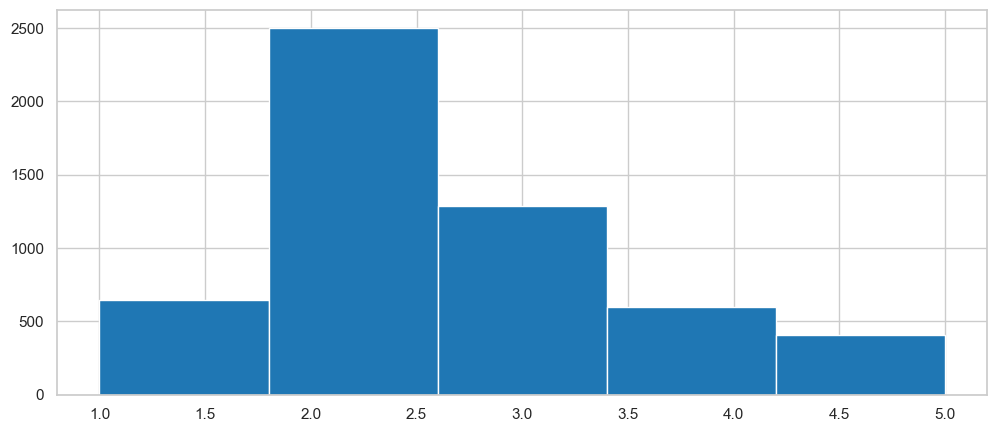

In [7]:
train_set['price_range'] = pd.cut(train_set.Price, bins=[.0, .5e6, 1e6, 1.5e6, 2e6, 10e6], labels=[1, 2, 3, 4, 5])
train_set['price_range'].hist(bins=5)

In [8]:
def train_val_split(train_set: pd.DataFrame, stratify_col: str = 'price_range'):
    train_set_target = train_set[stratify_col]

    X_train, X_valid, Y_train, Y_valid = train_test_split(
        train_set, 
        train_set_target, 
        stratify=train_set_target, 
        test_size=.15,
        random_state=0
    )
    
    return pd.concat([X_train, Y_train], axis=1), pd.concat([X_valid, Y_valid], axis=1)

In [9]:
train_set, valid_set = train_val_split(train_set)

In [10]:
train_set.drop(['price_range'], axis=1, inplace=True)
valid_set.drop(['price_range'], axis=1, inplace=True)

## EDA

In [11]:
train_set.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,4617.000000,4.617000e+03,4617.000000,4617.000000,4617.000000,4617.000000,4595.000000,4617.000000,2435.000000,2801.000000,4617.000000,4617.000000,4617.000000
mean,2.938705,1.078467e+06,10.261057,3105.903617,2.918562,1.537362,1.631338,538.927442,167.292700,1965.311674,-37.810119,144.994463,7379.346979
std,0.951790,6.454600e+05,6.038494,94.448991,0.993194,0.699995,0.990320,1614.688646,917.783312,36.274513,0.079175,0.108455,4341.521714
min,1.000000,1.450000e+05,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.174880,144.542370,389.000000
25%,2.000000,6.500000e+05,6.200000,3044.000000,2.000000,1.000000,1.000000,185.000000,92.000000,1940.000000,-37.857100,144.927500,4217.000000
50%,3.000000,9.000000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,451.000000,125.000000,1970.000000,-37.803500,144.999400,6543.000000
75%,3.000000,1.331000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,656.000000,175.000000,2000.000000,-37.757690,145.058790,10331.000000
max,8.000000,8.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


<AxesSubplot:xlabel='Type', ylabel='count'>

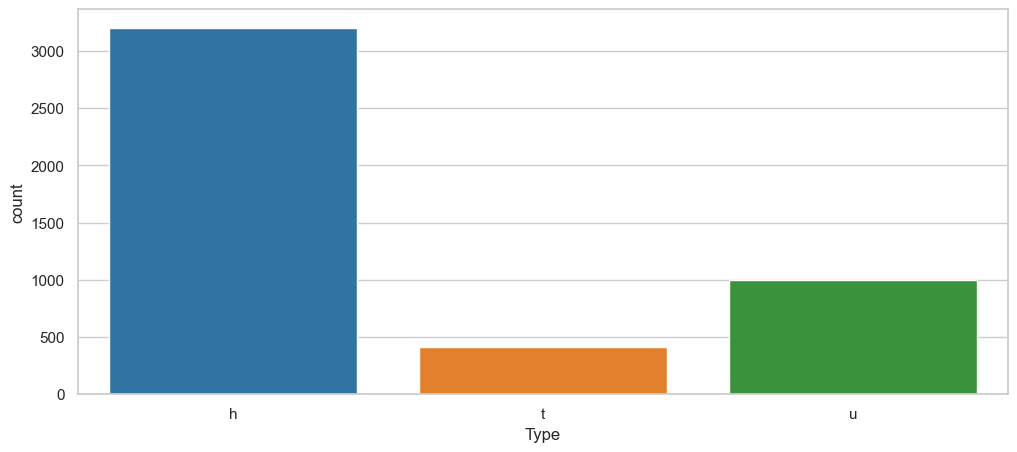

In [12]:
sns.countplot(x='Type', data=train_set)

<AxesSubplot:xlabel='Longtitude', ylabel='Lattitude'>

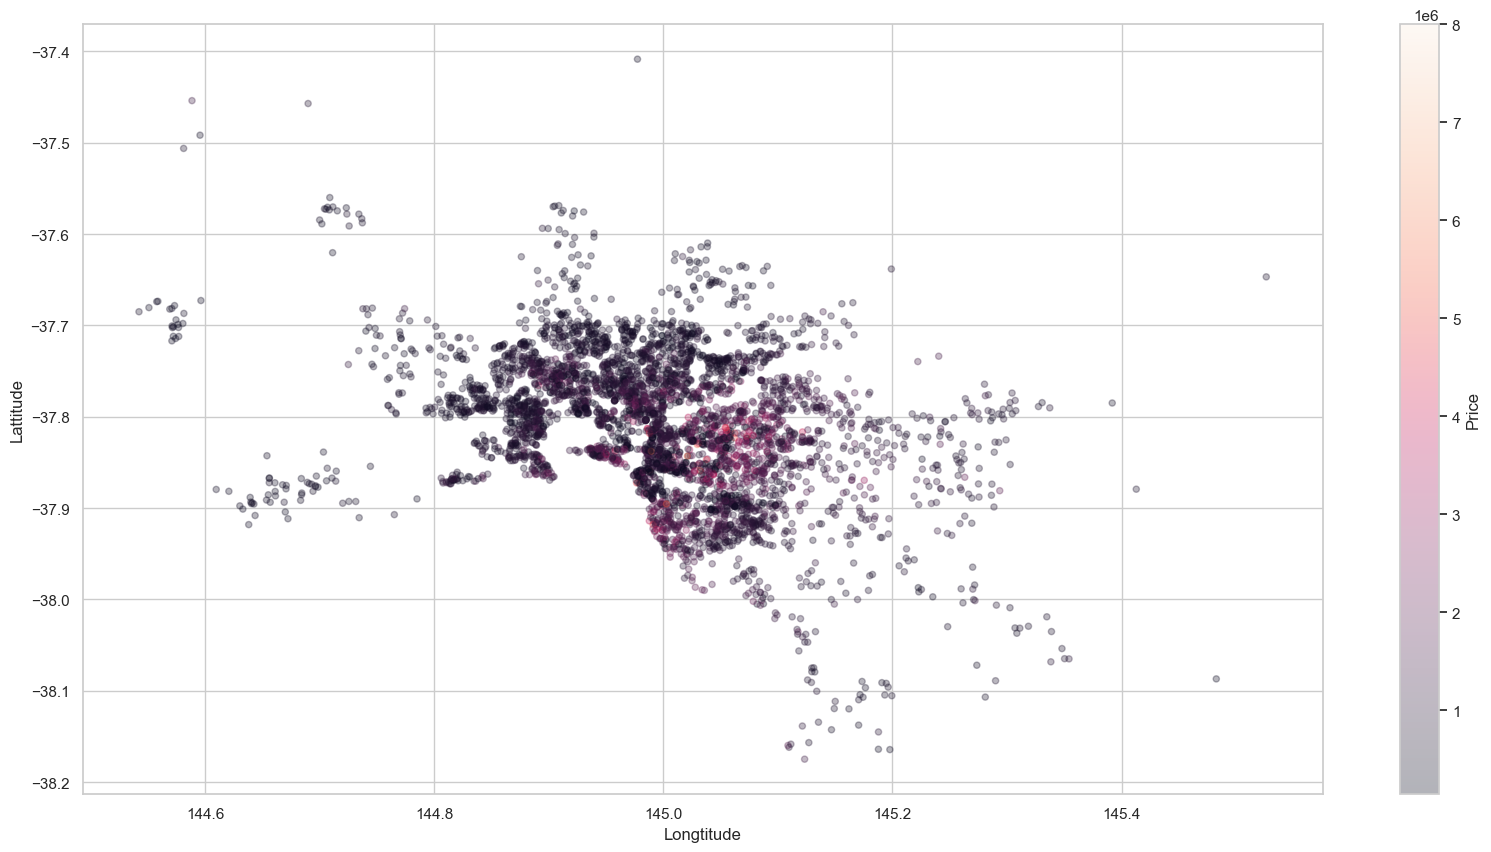

In [13]:
train_set.plot(
    kind='scatter',
    x='Longtitude',
    y='Lattitude',
    alpha=.3,
    figsize=(20, 10),
    c='Price', 
    cmap=plt.get_cmap('jet'),
    colorbar=True,
    sharex=False
)

<AxesSubplot:>

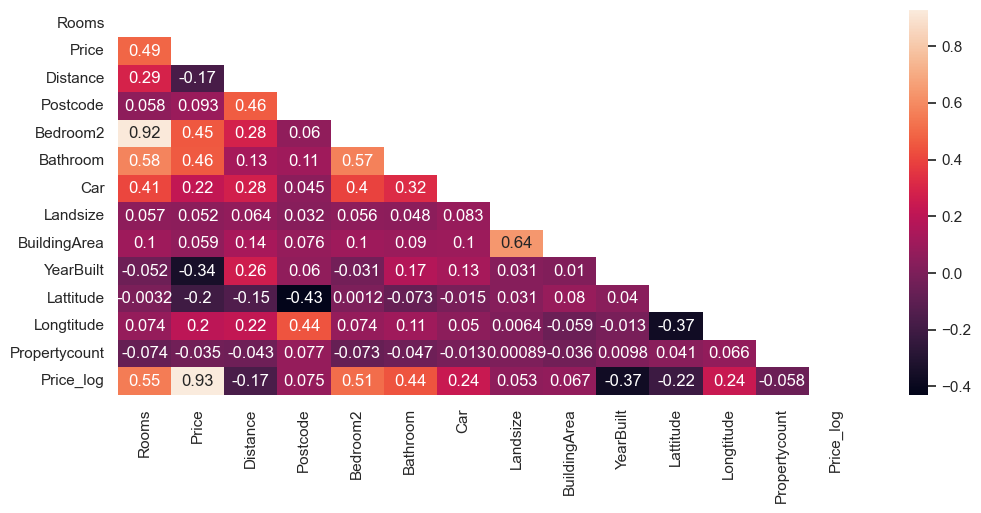

In [14]:
train_set.loc[:, 'Price_log'] = np.log(train_set['Price'])
corr = train_set.corr(numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(
    corr,
    annot=True,
    mask=matrix
)

In [15]:
corr_sorted = corr['Price'].sort_values()
corr_sorted

YearBuilt       -0.344287
Lattitude       -0.204988
Distance        -0.174566
Propertycount   -0.035337
Landsize         0.051705
BuildingArea     0.059124
Postcode         0.092615
Longtitude       0.200117
Car              0.219901
Bedroom2         0.450831
Bathroom         0.457246
Rooms            0.488317
Price_log        0.927824
Price            1.000000
Name: Price, dtype: float64

In [16]:
corr_sorted = corr['Price_log'].sort_values()
corr_sorted

YearBuilt       -0.370563
Lattitude       -0.216350
Distance        -0.167657
Propertycount   -0.058089
Landsize         0.053004
BuildingArea     0.066616
Postcode         0.075252
Longtitude       0.239240
Car              0.242657
Bathroom         0.442409
Bedroom2         0.513359
Rooms            0.553088
Price            0.927824
Price_log        1.000000
Name: Price_log, dtype: float64

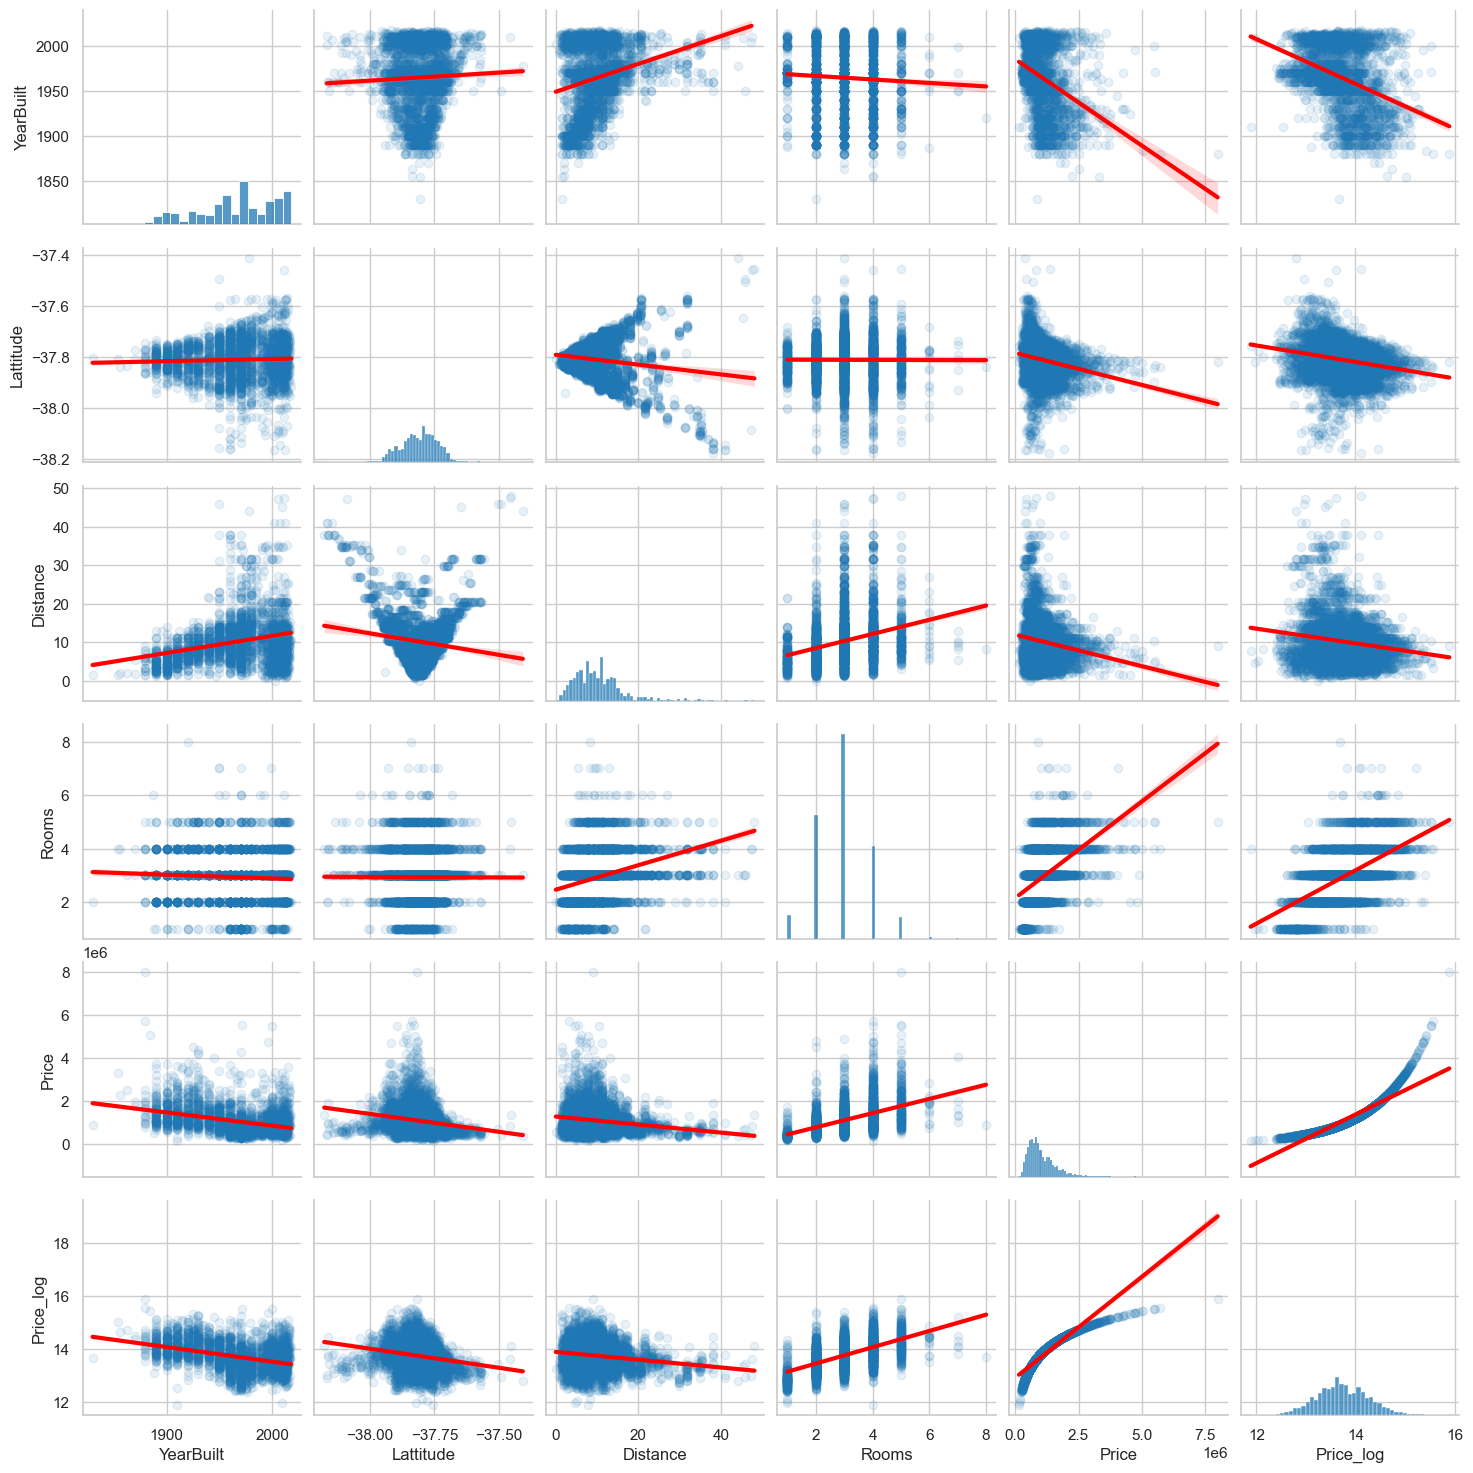

In [17]:
# Will do pair plot with most correlated values
sns.pairplot(
    train_set[corr_sorted.index[:3].tolist() + corr_sorted.index[-3:].tolist()],
    kind='reg',
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}}
)

## Data Processing

In [18]:
print(train_set.isnull().sum(axis=0).to_string())

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                22
Landsize            0
BuildingArea     2182
YearBuilt        1816
CouncilArea       477
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
Price_log           0


In [199]:
train_set_processed = train_set.copy()
valid_set_processed = valid_set.copy()
test_set_processed = test_set.copy()

Decided not to handle outliers, but create models that are robust to them. As outliers are a valid data from our dataset.

### Handling NaNs

#### Car

<AxesSubplot:xlabel='Price', ylabel='Count'>

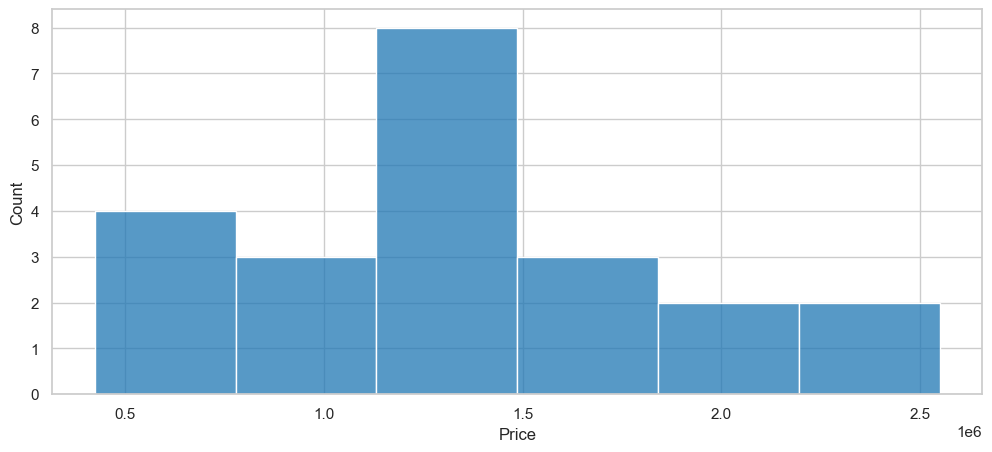

In [200]:
# How is the distribution of price when car is not set
sns.histplot(
    train_set_processed[train_set_processed.Car.isnull()]['Price']
)

In [201]:
def handle_null_car(train_df, valid_df, test_df, year_not_car: int = 1940):
    """
    We will assume that for the nulls in the year before year_not_car, are because there as effectively no car.
    
    """
    
    # For the other ones would place the median
    train_set_median = train_df['Car'].median()
    
    # For very aged houses
    train_df.loc[
        train_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0

    valid_df.loc[
        valid_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0

    test_df.loc[
        test_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0
    
    
    # And for the other houses
    train_df['Car'].fillna(train_set_median, inplace=True)
    valid_df['Car'].fillna(train_set_median, inplace=True)
    test_df['Car'].fillna(train_set_median, inplace=True)
    
    return train_df, valid_df, test_df

In [202]:
train_set_processed, valid_set_processed, test_set_processed = handle_null_car(train_set_processed, valid_set_processed, test_set_processed)

####  BuildingArea

In [203]:
def get_df_valid_size(df: pd.DataFrame, column: str):
    return df[
        (~df[column].isnull()) &
        (df[column] > 0)
    ]

In [204]:
def get_df_invalid_size(df: pd.DataFrame, column: str):
    return df[
        (df[column].isnull()) |
        (df[column] <= 0)
    ]

In [205]:
# We can see that half of the dataset is not useful
building_area_train_base = get_df_valid_size(train_set_processed, 'BuildingArea')
building_area_train_target = get_df_invalid_size(train_set_processed, 'BuildingArea')

print('Valid building area shape: ', building_area_train_base.shape)
print('Invalid building area shape: ', building_area_train_target.shape)

Valid building area shape:  (2429, 22)
Invalid building area shape:  (2188, 22)


We can try to find an easy relationship to the building area.

In [206]:
building_area_train_base.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
index,,,,,,,,,,,,,,,,,,,,,,
1845,Kensington,51 Rankins Rd,2,h,765000.0,S,Nardella,10/12/2016,4.2,3031.0,2.0,1.0,2.0,158.0,76.0,1965.0,Melbourne,-37.7902,144.9319,Northern Metropolitan,5263.0,13.547631
1609,Hawthorn East,3 Jaques St,5,h,2500000.0,VB,RT,22/08/2016,7.5,3123.0,5.0,3.0,0.0,757.0,240.0,1925.0,Boroondara,-37.8176,145.0548,Southern Metropolitan,6482.0,14.731801
1329,Brighton,95 Cochrane St,4,h,3295888.0,S,Hodges,15/10/2016,11.2,3186.0,4.0,3.0,2.0,565.0,337.0,1990.0,Bayside,-37.8975,144.9991,Southern Metropolitan,10579.0,15.008186


In [207]:
from typing import List

def create_logs(df: pd.DataFrame, columns: List[str] = ['BuildingArea', 'Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'YearBuilt']):
    for col in columns:
        df[col + '_log'] = np.log(df[col] + 1)
    
    df.replace([np.inf, -np.inf], 0, inplace=True)

    return df

In [208]:
# And we find that there are relationships of log-log of nearly 60&
building_area_train_base = create_logs(building_area_train_base)

building_area_train_base[
    ['BuildingArea', 'BuildingArea_log', 
    'Rooms', 'Bathroom', 'Bedroom2', 'Car',
    'Rooms_log', 'Bedroom2_log', 'Bathroom_log', 'Car_log']
].corr()\
    .sort_values('BuildingArea_log')

,BuildingArea,BuildingArea_log,Rooms,Bathroom,Bedroom2,Car,Rooms_log,Bedroom2_log,Bathroom_log,Car_log
Car_log,0.054543,0.123135,0.185633,0.189973,0.200415,0.952129,0.188723,0.203586,0.198270,1.000000
Car,0.082404,0.176139,0.249816,0.211311,0.260762,1.000000,0.250283,0.261262,0.217959,0.952129
BuildingArea,1.000000,0.298051,0.102986,0.090071,0.101215,0.082404,0.093942,0.092273,0.088312,0.054543
Bathroom,0.090071,0.472635,0.600139,1.000000,0.622556,0.211311,0.570584,0.579273,0.985693,0.189973
Bathroom_log,0.088312,0.487082,0.611385,0.985693,0.621076,0.217959,0.587054,0.588788,1.000000,0.198270
Bedroom2,0.101215,0.575477,0.944879,0.622556,1.000000,0.260762,0.932731,0.980448,0.621076,0.200415
Bedroom2_log,0.092273,0.581451,0.931077,0.579273,0.980448,0.261262,0.948541,1.000000,0.588788,0.203586
Rooms,0.102986,0.591785,1.000000,0.600139,0.944879,0.249816,0.983660,0.931077,0.611385,0.185633
Rooms_log,0.093942,0.597784,0.983660,0.570584,0.932731,0.250283,1.000000,0.948541,0.587054,0.188723
BuildingArea_log,0.298051,1.000000,0.591785,0.472635,0.575477,0.176139,0.597784,0.581451,0.487082,0.123135


So for this model, seems the variables that have great influence in the building area log are:
- Car
- Bathroom Logarithm
- Bedroom2 Logarithm
- Rooms Logarithm

In [209]:
building_area_features = ['Car', 'Bathroom_log', 'Bedroom2_log', 'Rooms_log']

In [210]:
Y_building_area_train_base = building_area_train_base.BuildingArea_log
X_building_area_train_base = building_area_train_base[building_area_features]

In [211]:
building_area_scaler = StandardScaler()
X_building_area_train_base = building_area_scaler.fit_transform(X_building_area_train_base)

In [212]:
# Huber Regressor is robust agains outliers
ba_linear_model = HuberRegressor().fit(X_building_area_train_base, Y_building_area_train_base)

In [213]:
# Can see in the train set which is r2 scoring
from sklearn.metrics import r2_score
round(r2_score(Y_building_area_train_base, ba_linear_model.predict(X_building_area_train_base)), 2)

0.38

And now we will use this model to imput the missing values in the building area.

In [214]:
from copy import deepcopy

def input_nan_logarithms(
    model, 
    scaler, 
    df: pd.DataFrame, 
    column_target: str, 
    column_features,
    log: bool = True,
    logging: bool = True,
):
    
    """
    Input the nans with a given model with the linear regression model for logarithms.
    Also, computes the MSE for the base dataframe (the one without nan).
    - model: the model trained
    - scaler: StandardScaler fitted
    - df: the dataframe for which we want to replace the nans
    - column_target: for which column do we want to replace the NaNs
    - column_features: list of features used from the df
    - log: if we are predicting a logarithm
    - logging: if we want to print out scores
    """
    df = deepcopy(df)
    column_target_model = column_target + '_log' if log else column_target
    
    # Get the valid and invalid dataframes
    base_df = get_df_valid_size(df, column_target)
    target_df = get_df_invalid_size(df, column_target)
    
    # Create the log features
    base_df = create_logs(base_df)
    target_df = create_logs(target_df)
    
    # Apply scaling
    Y_base_df = base_df[column_target_model]  # we expect the log of that variable
    X_base_df = base_df[column_features]
    X_base_df = scaler.transform(X_base_df)
    
    X_target_df = target_df[column_features]
    X_target_df = scaler.transform(X_target_df)
    Y_target_df_idx = target_df.index.values

    # And now we make the predictions
    prediction_base = model.predict(X_base_df)
    prediction_target = model.predict(X_target_df)
    
    # We compute scoring on the base
    comparison = [Y_base_df, prediction_base]
    comparison = [np.exp(x) if log else x for x in comparison]
    
    # Compute accuracy on the base
    if logging:
        print('-'*20)
        print('MSE error: ', mean_squared_error(
            *comparison,
            squared=False
        ))

        print('R2 error: ', r2_score(
            *comparison,
        ))
        print('-'*20)
    
    # And finally we fill with the exponential
    df.loc[
        Y_target_df_idx,
        column_target
    ] = np.exp(prediction_target)
    
    return df

In [215]:
train_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, train_set_processed, 'BuildingArea', building_area_features, logging=False)
valid_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, valid_set_processed, 'BuildingArea', building_area_features)
test_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, test_set_processed, 'BuildingArea', building_area_features)

--------------------
MSE error:  69.52603252744271
R2 error:  0.3736920793256484
--------------------
--------------------
MSE error:  65.35100789196404
R2 error:  0.4321189081638367
--------------------


#### Landsize

This one does not have nulls, but have land size of 0. Which are values we can assumed that were put when they did not have a value for the land size.

Same analysis as before, but could include now the Building area & building area logs

In [216]:
# We can see that half of the dataset is not useful
landsize_train_base = get_df_valid_size(train_set_processed, 'Landsize')
landsize_train_target = get_df_invalid_size(train_set_processed, 'Landsize')

print('Valid landsize shape: ', landsize_train_base.shape)
print('Invalid landsize shape: ', landsize_train_target.shape)

Valid landsize shape:  (3996, 22)
Invalid landsize shape:  (621, 22)


In [217]:
landsize_train_base = create_logs(landsize_train_base)

landsize_train_base[
    ['Landsize', 'Landsize_log', 'BuildingArea', 'BuildingArea_log', 
    'Rooms', 'Bathroom', 'Bedroom2', 'Car',
    'Rooms_log', 'Bedroom2_log', 'Bathroom_log', 'Car_log']
].corr()\
    .sort_values('Landsize_log')

,Landsize,Landsize_log,BuildingArea,BuildingArea_log,Rooms,Bathroom,Bedroom2,Car,Rooms_log,Bedroom2_log,Bathroom_log,Car_log
Bathroom_log,0.025984,0.120748,0.090788,0.561102,0.574853,0.985606,0.551366,0.211800,0.552880,0.543217,1.000000,0.204452
BuildingArea,0.397040,0.124420,1.000000,0.298764,0.104459,0.093366,0.097991,0.067220,0.096865,0.092914,0.090788,0.047003
Bathroom,0.028074,0.128715,0.093366,0.550199,0.574058,1.000000,0.558348,0.205617,0.547071,0.540033,0.985606,0.194081
BuildingArea_log,0.070046,0.221018,0.298764,1.000000,0.653532,0.550199,0.609013,0.203775,0.657738,0.626760,0.561102,0.173272
Car_log,0.059392,0.242184,0.047003,0.173272,0.206480,0.194081,0.210083,0.950907,0.215144,0.222460,0.204452,1.000000
Bedroom2_log,-0.003718,0.245748,0.092914,0.626760,0.903210,0.540033,0.964489,0.252774,0.917855,1.000000,0.543217,0.222460
Car,0.061744,0.252944,0.067220,0.203775,0.245354,0.205617,0.242454,1.000000,0.251051,0.252774,0.211800,0.950907
Rooms_log,-0.006388,0.256403,0.096865,0.657738,0.985214,0.547071,0.887081,0.251051,1.000000,0.917855,0.552880,0.215144
Bedroom2,0.006477,0.261295,0.097991,0.609013,0.898000,0.558348,1.000000,0.242454,0.887081,0.964489,0.551366,0.210083
Rooms,0.003948,0.273136,0.104459,0.653532,1.000000,0.574058,0.898000,0.245354,0.985214,0.903210,0.574853,0.206480


Have tried training for both Landsize & Landsize log, and I get better R2 scoring for the Landsize.

In [218]:
landsize_features = ['Bathroom', 'BuildingArea', 'Car', 'Rooms', 'Bedroom2']

In [219]:
Y_landsize_train_base = landsize_train_base.Landsize
X_landsize_train_base = landsize_train_base[landsize_features]

In [220]:
landsize_scaler = StandardScaler()
X_landsize_train_base = landsize_scaler.fit_transform(X_landsize_train_base)

In [221]:
ls_linear_model = HuberRegressor().fit(X_landsize_train_base, Y_landsize_train_base)

In [222]:
round(r2_score(Y_landsize_train_base, ls_linear_model.predict(X_landsize_train_base)), 2)

0.15

Will try to fill the NaNs with the model.

In [223]:
_ = input_nan_logarithms(ls_linear_model, landsize_scaler, train_set_processed, 'Landsize', landsize_features, log=False, logging=False)
_ = input_nan_logarithms(ls_linear_model, landsize_scaler, valid_set_processed, 'Landsize', landsize_features, log=False)
_ = input_nan_logarithms(ls_linear_model, landsize_scaler, test_set_processed, 'Landsize', landsize_features, log=False)

--------------------
MSE error:  1209.6312618242114
R2 error:  -0.023287764011138856
--------------------
--------------------
MSE error:  5404.301454853171
R2 error:  -0.001995399235138251
--------------------


In [224]:
# We can see a huge MSE, so we will go for another way to fill the nans
pd.DataFrame(train_set_processed\
    .groupby(['Regionname', 'Type'])\
    .median(numeric_only=True)['Landsize'])\
    .T

Regionname Eastern Metropolitan               Eastern Victoria         \
Type                          h      t      u                h      u   
Landsize                  696.5  229.0  211.0            741.5  213.0   

Regionname Northern Metropolitan             Northern Victoria  \
Type                           h      t    u                 h   
Landsize                   454.0  123.5  0.0             753.5   

Regionname South-Eastern Metropolitan               Southern Metropolitan  \
Type                                h      t      u                     h   
Landsize                        606.0  269.0  199.0                 588.0   

Regionname             Western Metropolitan               Western Victoria  
Type            t    u                    h      t      u                h  
Landsize    266.0  0.0                534.0  201.0  126.5            590.0

In [225]:
# First, we will handle this grouping
train_set_processed['Regionname'].value_counts()

Southern Metropolitan         1575
Northern Metropolitan         1286
Western Metropolitan          1034
Eastern Metropolitan           504
South-Eastern Metropolitan     169
Eastern Victoria                20
Western Victoria                15
Northern Victoria               14
Name: Regionname, dtype: int64

In [226]:
other_region_name_cols = ['Eastern Victoria', 'Western Victoria', 'Northern Victoria']

train_set_processed.loc[
    train_set_processed['Regionname'].isin(other_region_name_cols),
    'Regionname'
] = 'Other'

valid_set_processed.loc[
    valid_set_processed['Regionname'].isin(other_region_name_cols),
    'Regionname'
] = 'Other'

test_set_processed.loc[
    test_set_processed['Regionname'].isin(other_region_name_cols),
    'Regionname'
] = 'Other'

In [227]:
# And we can check again
train_set_processed['Regionname'].value_counts()

Southern Metropolitan         1575
Northern Metropolitan         1286
Western Metropolitan          1034
Eastern Metropolitan           504
South-Eastern Metropolitan     169
Other                           49
Name: Regionname, dtype: int64

In [228]:
landsize_by_region_type = pd.DataFrame(train_set_processed\
    .groupby(['Regionname', 'Type'])\
    .median(numeric_only=True)['Landsize'])  # median to do not be influenced by outliers of the 0

landsize_by_region_type.T

Regionname Eastern Metropolitan               Northern Metropolitan         \
Type                          h      t      u                     h      t   
Landsize                  696.5  229.0  211.0                 454.0  123.5   

Regionname       Other        South-Eastern Metropolitan                \
Type          u      h      u                          h      t      u   
Landsize    0.0  675.0  213.0                      606.0  269.0  199.0   

Regionname Southern Metropolitan             Western Metropolitan         \
Type                           h      t    u                    h      t   
Landsize                   588.0  266.0  0.0                534.0  201.0   

Regionname         
Type            u  
Landsize    126.5

In [229]:
# And this one will be used in the case we get a 0
landsize_by_region = pd.DataFrame(train_set_processed\
    .groupby(['Regionname'])\
    .median(numeric_only=True)['Landsize'])

landsize_by_region.T

Regionname,Eastern Metropolitan,Northern Metropolitan,Other,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan
Landsize,649.5,326.5,675.0,590.0,375.0,463.0


Will use this as a hash map, of values that will be replaced for the NaN of the dataframes.

In [230]:
def handle_null_landsize(df: pd.DataFrame):
    for idx, row in df.iterrows():
        landsize = row['Landsize']
        
        if pd.isnull(landsize) or landsize == 0:
            region_name = row['Regionname']
            type_name = row['Type']
            
            new_value = landsize_by_region_type.loc[region_name, type_name].values[0]
            new_value = new_value if new_value > 0.0 else landsize_by_region.loc[region_name].values[0]
            
            df.loc[
                idx, 'Landsize'
            ] = new_value
    
    return df

In [231]:
train_set_processed = handle_null_landsize(train_set_processed)
valid_set_processed = handle_null_landsize(valid_set_processed)
test_set_processed = handle_null_landsize(test_set_processed)

#### CouncilArea

Will can try to use a **k-nearest neighbor**, as the council area depends a lot in the position of longtitude and lattitude.

In [232]:
train_set_processed.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
index,,,,,,,,,,,,,,,,,,,,,,
1845,Kensington,51 Rankins Rd,2,h,765000.0,S,Nardella,10/12/2016,4.2,3031.0,2.0,1.0,2.0,158.0,76.000000,1965.0,Melbourne,-37.79020,144.93190,Northern Metropolitan,5263.0,13.547631
828,Blackburn,18 Masons Rd,2,h,1500000.0,S,Noel,15/07/2017,13.4,3130.0,2.0,1.0,1.0,1021.0,83.389149,NaN,Whitehorse,-37.83189,145.15785,Eastern Metropolitan,5713.0,14.220976
973,Preston,1/61 Eton St,3,h,485000.0,PI,Barry,12/11/2016,8.8,3072.0,3.0,1.0,1.0,244.0,117.473722,NaN,Darebin,-37.74440,145.02020,Northern Metropolitan,14577.0,13.091904


In [233]:
test_set_processed.isnull().sum(axis=0)

Suburb              0
Address             0
Rooms               0
Type                0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea        0
YearBuilt        3245
CouncilArea       816
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [234]:
train_set_base = train_set_processed.dropna(subset=['CouncilArea'])
train_set_target = train_set_processed[train_set_processed['CouncilArea'].isna()]

# Explicative variables
X_train_base_set_council = train_set_base[['Lattitude', 'Longtitude']]
X_train_target_set_council = train_set_target[['Lattitude', 'Longtitude']]
X_train_target_set_council_index = X_train_target_set_council.index

# Target variables
Y_train_base_set_council = train_set_base['CouncilArea'].values.ravel()

In [235]:
# Scale the inputs
scaler = StandardScaler()

X_train_base_set_council = scaler.fit_transform(X_train_base_set_council)
X_train_target_set_council = scaler.transform(X_train_target_set_council)

In [236]:
# Train the model
n_council_area = train_set_processed['CouncilArea'].nunique()
knn_council_area = KNeighborsClassifier(n_council_area)

knn_council_area.fit(X_train_base_set_council, Y_train_base_set_council)

KNeighborsClassifier(n_neighbors=32)

In [237]:
valid_set_base = valid_set_processed.dropna(subset='CouncilArea')
X_valid_base_set_council = valid_set_base[['Lattitude', 'Longtitude']]
Y_valid_base_set_council = valid_set_base['CouncilArea'].values.ravel()

accuracy_score(knn_council_area.predict(X_valid_base_set_council), Y_valid_base_set_council)

0.0027063599458728013

We can see that this is not giving us very good results.

In [238]:
train_set_processed['CouncilArea'].value_counts()

Boroondara           420
Moreland             379
Moonee Valley        328
Darebin              317
Glen Eira            286
Stonnington          242
Maribyrnong          236
Yarra                227
Banyule              194
Port Phillip         191
Brimbank             158
Bayside              157
Hobsons Bay          155
Melbourne            154
Whitehorse           116
Monash               107
Manningham           101
Kingston              70
Hume                  53
Whittlesea            41
Wyndham               35
Maroondah             34
Knox                  34
Melton                29
Casey                 19
Greater Dandenong     17
Frankston             17
Nillumbik             13
Yarra Ranges           6
Macedon Ranges         2
Unavailable            1
Cardinia               1
Name: CouncilArea, dtype: int64

In [239]:
train_set_processed['CouncilArea'].fillna('Unknown', inplace=True)
valid_set_processed['CouncilArea'].fillna('Unknown', inplace=True)
test_set_processed['CouncilArea'].fillna('Unknown', inplace=True)

### YearBuilt

In [240]:
# We can see that half of the dataset is not useful
yearbuilt_train_base = get_df_valid_size(train_set_processed, 'YearBuilt')
yearbuilt_train_target = get_df_invalid_size(train_set_processed, 'YearBuilt')

print('Valid year built shape: ', yearbuilt_train_base.shape)
print('Invalid year built shape: ', yearbuilt_train_target.shape)

Valid year built shape:  (2801, 22)
Invalid year built shape:  (1816, 22)


In [241]:
yearbuilt_train_base = create_logs(yearbuilt_train_base)

yearbuilt_train_base[
    ['YearBuilt', 'YearBuilt_log', 'Landsize', 'Landsize_log', 'BuildingArea', 'BuildingArea_log', 
    'Rooms', 'Bathroom', 'Bedroom2', 'Car',
    'Rooms_log', 'Bedroom2_log', 'Bathroom_log', 'Car_log']
].corr()\
    .sort_values('YearBuilt_log')

,YearBuilt,YearBuilt_log,Landsize,Landsize_log,BuildingArea,BuildingArea_log,Rooms,Bathroom,Bedroom2,Car,Rooms_log,Bedroom2_log,Bathroom_log,Car_log
Rooms_log,-0.056214,-0.056585,-0.004781,0.264055,0.560872,0.723519,0.983650,0.574446,0.936184,0.236880,1.000000,0.951975,0.587920,0.169639
Rooms,-0.052247,-0.052534,0.003046,0.288586,0.584902,0.720436,1.000000,0.606033,0.948620,0.235211,0.983650,0.934433,0.614393,0.165618
Bedroom2_log,-0.034455,-0.034822,-0.003436,0.256538,0.544406,0.703298,0.934433,0.579614,0.980780,0.246213,0.951975,1.000000,0.586285,0.183671
Bedroom2,-0.031225,-0.031507,0.004685,0.283179,0.567339,0.700777,0.948620,0.624594,1.000000,0.244425,0.936184,0.980780,0.620874,0.179543
Landsize_log,-0.022088,-0.019467,0.555920,1.000000,0.222468,0.238338,0.288586,0.176992,0.283179,0.227653,0.264055,0.256538,0.172450,0.195090
BuildingArea_log,-0.016580,-0.017569,0.012920,0.238338,0.769344,1.000000,0.720436,0.574688,0.700777,0.209780,0.723519,0.703298,0.586641,0.148509
BuildingArea,0.002039,0.001105,0.020725,0.222468,1.000000,0.769344,0.584902,0.498012,0.567339,0.150295,0.560872,0.544406,0.499321,0.101729
Landsize,0.044958,0.045044,1.000000,0.555920,0.020725,0.012920,0.003046,0.054429,0.004685,0.064246,-0.004781,-0.003436,0.055845,0.063227
Bathroom,0.172785,0.170563,0.054429,0.176992,0.498012,0.574688,0.606033,1.000000,0.624594,0.217656,0.574446,0.579614,0.986411,0.189202
Bathroom_log,0.186393,0.184063,0.055845,0.172450,0.499321,0.586641,0.614393,0.986411,0.620874,0.225627,0.587920,0.586285,1.000000,0.198723


So we could try out a model with:
- Car Logarithm
- Car
- Bathroom Logarithm
- Bathroom

In [242]:
yearbuilt_features = ['Car_log', 'Car', 'Bathroom_log', 'Bathroom']
Y_yearbuilt_train_base = yearbuilt_train_base.YearBuilt_log
X_yearbuilt_train_base = yearbuilt_train_base[yearbuilt_features]

In [243]:
yearbuilt_scaler = StandardScaler()
X_yearbuilt_train_base = yearbuilt_scaler.fit_transform(X_yearbuilt_train_base)
yb_linear_model = HuberRegressor().fit(X_yearbuilt_train_base, Y_yearbuilt_train_base)

In [244]:
# And we can see a model that has good 
round(r2_score(Y_yearbuilt_train_base, yb_linear_model.predict(X_yearbuilt_train_base)), 2)

0.57

In [245]:
train_set_processed = input_nan_logarithms(yb_linear_model, yearbuilt_scaler, train_set_processed, 'YearBuilt', yearbuilt_features, logging=False)
valid_set_processed = input_nan_logarithms(yb_linear_model, yearbuilt_scaler, valid_set_processed, 'YearBuilt', yearbuilt_features)
test_set_processed = input_nan_logarithms(yb_linear_model, yearbuilt_scaler, test_set_processed, 'YearBuilt', yearbuilt_features)

--------------------
MSE error:  24.482902421279082
R2 error:  0.5393168281067002
--------------------
--------------------
MSE error:  26.198356178945414
R2 error:  0.5233523625812985
--------------------


With this, we have handled all the Nulls that we had for this df.

In [66]:
print(train_set_processed.isnull().sum(axis=0).to_string())

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
Price_log        0


## Handling Categorical Data

There are some categorical variables that have too much different values.

So instead of using all of them, we are going to group them depending if they tend to have high/medium/low price values.

In [246]:
def plot_distribution_grouped_field(
    df,
    field: str, 
    expensive_divisor: int = 1.5e6, 
    premium_divisor: int = 2e6,
    font_size: int = 6
):
    
    grouped_pricing = df\
        .groupby(field)\
        .mean()['Price']\
        .sort_values()
    
    grouped_names = grouped_pricing.index.values.tolist()

    fig, ax = plt.subplots(figsize=(20, 10))

    sns.scatterplot(
        x=grouped_names,
        y=grouped_pricing,
        ax=ax
    )

    plt.axhline(
        y=expensive_divisor, 
        color='green',
        linestyle='--',
        label='Expensive divisor'
    )

    plt.axhline(
        y=premium_divisor, 
        color='orange',
        linestyle='dotted',
        label='Premium divisor'
    )

    plt.xticks(
        size=font_size,
        rotation=90
    );

    plt.legend()
    
    return grouped_pricing, grouped_names

In [247]:
def classify_category(
    group_pricing, 
    df: pd.DataFrame,
    input_column_name: str,
    output_column_name: str,
    premium_threshold = 2e6,
    expensive_threshold = 1.5e6,
    
):
    
    # We get the group names
    premium_group = list(
        group_pricing[group_pricing >= premium_threshold].index.values
    )
    
    expensive_group = list(
        group_pricing[
            (group_pricing >= expensive_threshold) & 
            (group_pricing < premium_threshold)
        ].index.values
    )
    
    normal_group = list(
        group_pricing[group_pricing < expensive_threshold].index.values
    )
    
    # And now we make the classification
    df.loc[
        df[input_column_name].isin(premium_group), 
        output_column_name
    ] = 2

    df.loc[
        df[input_column_name].isin(expensive_group), 
        output_column_name
    ] = 1

    df.loc[
        df[input_column_name].isin(normal_group), 
        output_column_name
    ] = 0
    
    # And in the case some of it has not been classified: 0 as we consider them less than normal
    df[output_column_name].fillna(0, inplace=True)
    
    return df

### SellerG

In [248]:
train_set_processed.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
index,,,,,,,,,,,,,,,,,,,,,,
1845,Kensington,51 Rankins Rd,2,h,765000.0,S,Nardella,10/12/2016,4.2,3031.0,2.0,1.0,2.0,158.0,76.000000,1965.000000,Melbourne,-37.79020,144.93190,Northern Metropolitan,5263.0,13.547631
828,Blackburn,18 Masons Rd,2,h,1500000.0,S,Noel,15/07/2017,13.4,3130.0,2.0,1.0,1.0,1021.0,83.389149,1971.243876,Whitehorse,-37.83189,145.15785,Eastern Metropolitan,5713.0,14.220976
973,Preston,1/61 Eton St,3,h,485000.0,PI,Barry,12/11/2016,8.8,3072.0,3.0,1.0,1.0,244.0,117.473722,1971.243876,Darebin,-37.74440,145.02020,Northern Metropolitan,14577.0,13.091904


/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_92453/2600807695.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = df\


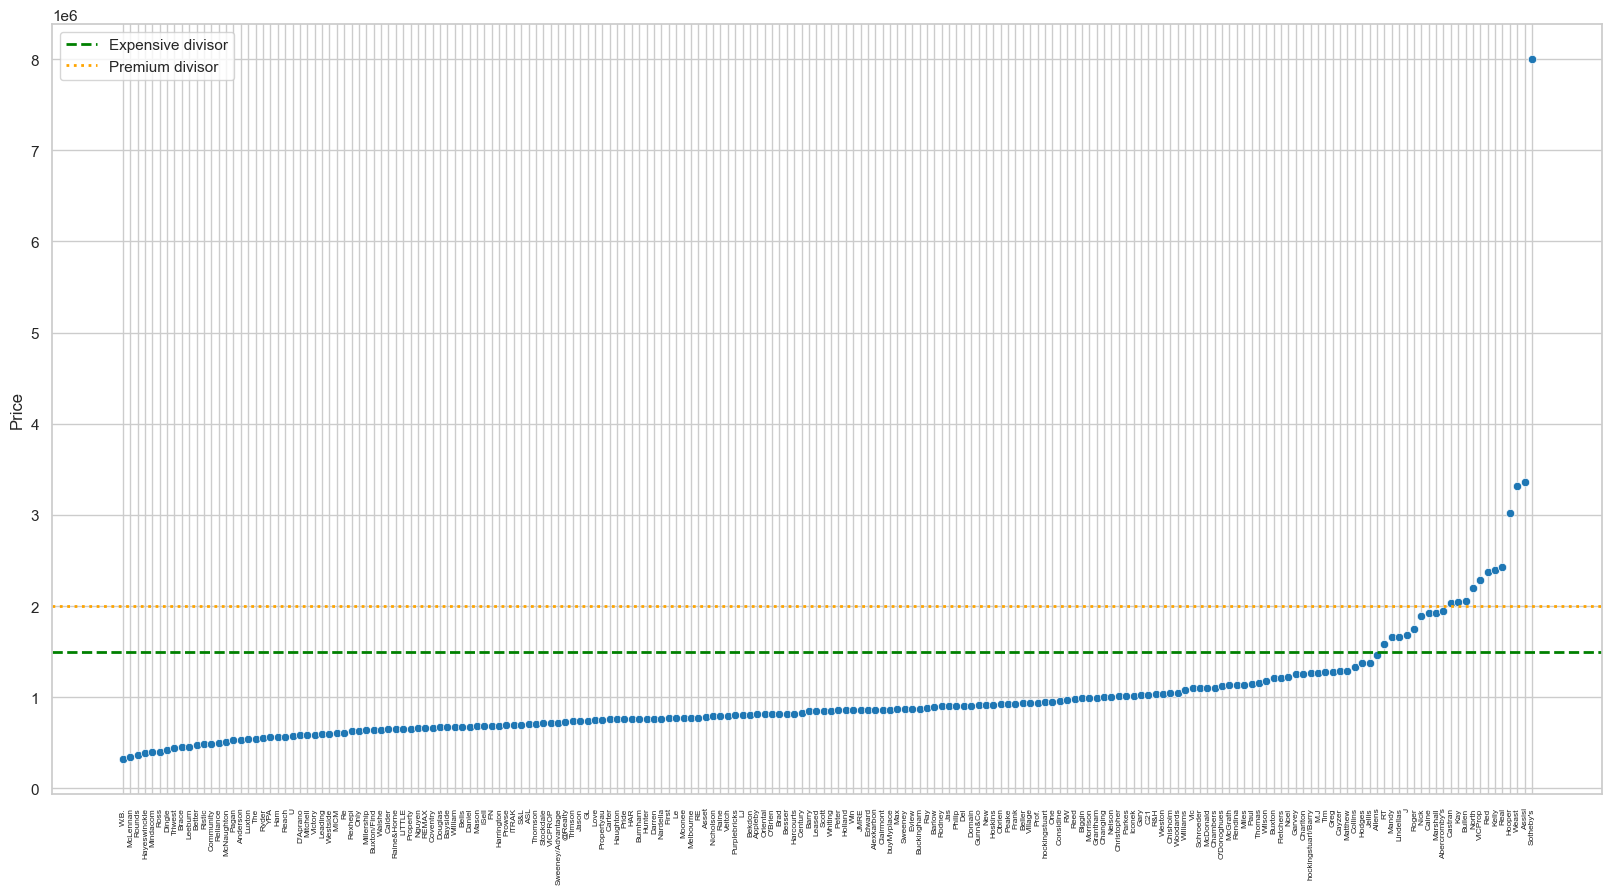

In [249]:
seller_pricing, _ = plot_distribution_grouped_field(train_set_processed, field='SellerG')

In [250]:
train_set_processed = classify_category(
    df=train_set_processed,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

valid_set_processed = classify_category(
    df=valid_set_processed,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

test_set_processed = classify_category(
    df=test_set_processed,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

Moreover, instead of bucketizing we can create a value that ranges from 0-1 that tells you how much that suburb pricing is.

TODO: Do not standard scale this value

In [251]:
def get_scoring_mean_price(df: pd.DataFrame, column_grouped: str):
    df_means = pd.DataFrame(df\
        .groupby(column_grouped)\
        .mean()['Price']\
        .sort_values())

    max_df_mean = df_means.Price.max()
    df_means['price_mean_proportion'] = df_means['Price'] / max_df_mean
    
    return df_means

In [252]:
seller_means = get_scoring_mean_price(train_set_processed, 'SellerG')

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_92453/4093301365.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_means = pd.DataFrame(df\


<AxesSubplot:>

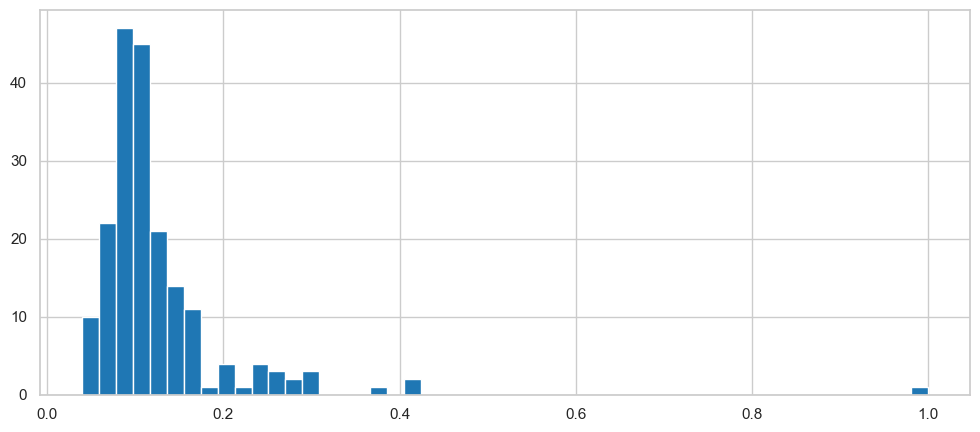

In [253]:
seller_means.price_mean_proportion.hist(bins=50)

In [254]:
def set_price_mean_proportions(
    df: pd.DataFrame, 
    df_price_mean: pd.DataFrame,
    target_column_df: str,
):
    # By default will be values of 0, in the case we have not seem some
    new_column = str(target_column_df + '_price_mean_prop').lower()
    df.loc[:, new_column] = .0
    
    for idx, row in df.iterrows():
        try:
            df.loc[idx, new_column] = df_price_mean.loc[row[target_column_df]].values[1]
        
        # In case some seller is not found
        except:
            df.loc[idx, new_column] = 0
            continue 
    
    return df

In [255]:
# And we place those values into the dataframe
train_set_processed = set_price_mean_proportions(train_set_processed, seller_means, 'SellerG')
valid_set_processed = set_price_mean_proportions(valid_set_processed, seller_means, 'SellerG')
test_set_processed = set_price_mean_proportions(test_set_processed, seller_means, 'SellerG')

In [256]:
# And remove the SellerG that will no longer be used
train_set_processed.drop(['SellerG'], axis=1, inplace=True)
valid_set_processed.drop(['SellerG'], axis=1, inplace=True)
test_set_processed.drop(['SellerG'], axis=1, inplace=True)

### Suburb

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_92453/2600807695.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = df\


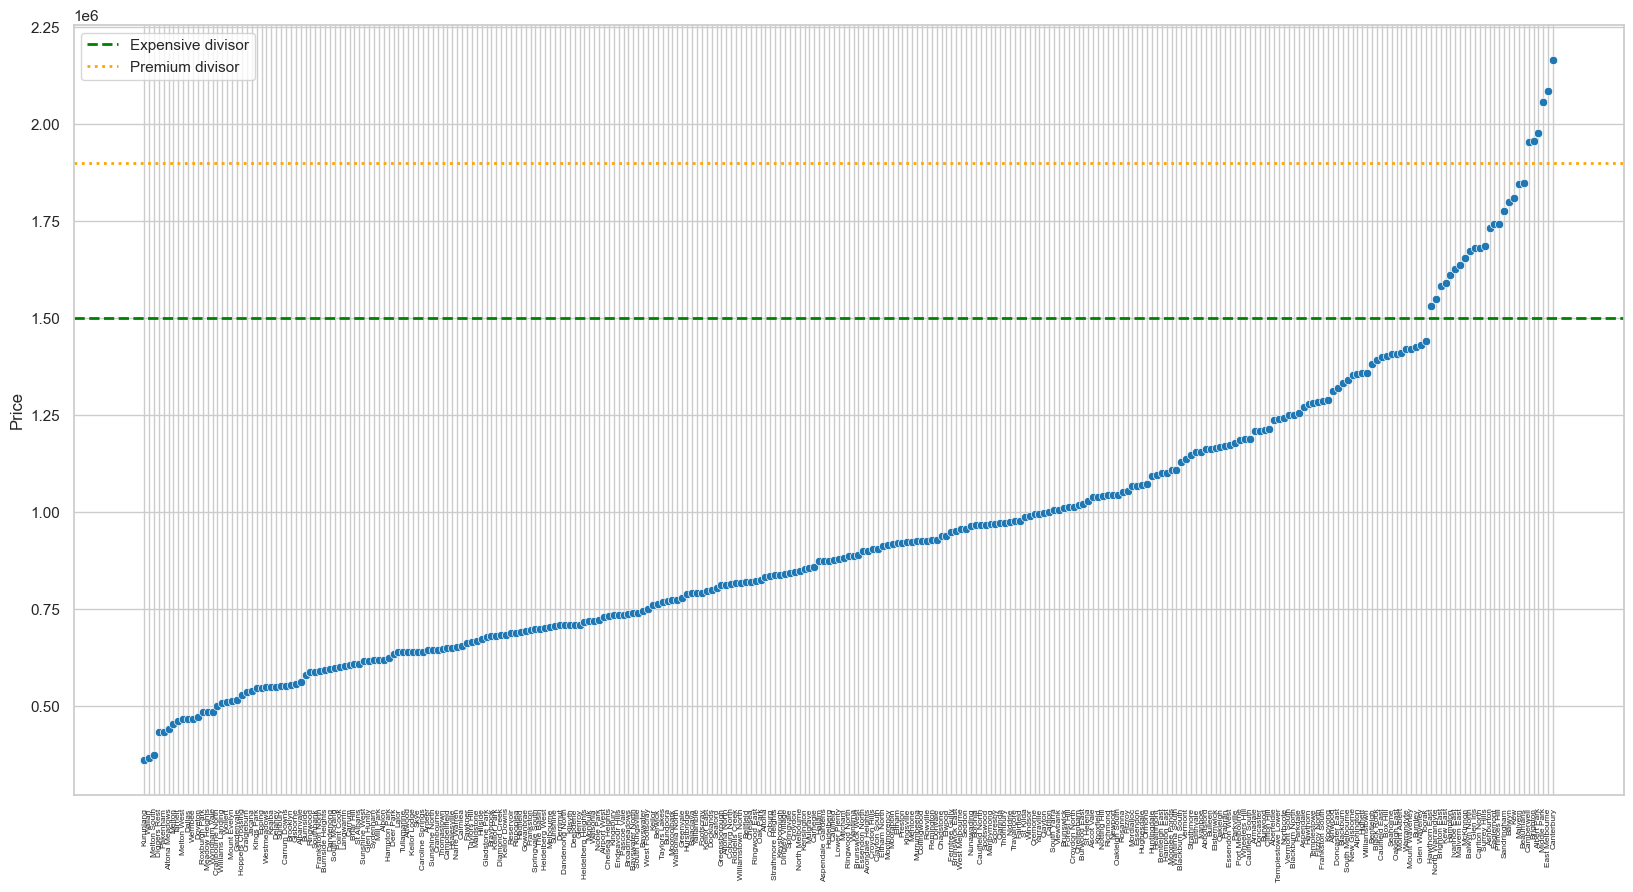

In [257]:
suburb_pricing, _ = plot_distribution_grouped_field(
    train_set_processed,
    field='Suburb', 
    expensive_divisor=1.5e6, 
    premium_divisor=1.9e6
)

In [258]:
train_set_processed = classify_category(
    df=train_set_processed,
    group_pricing=suburb_pricing,
    input_column_name='Suburb',
    output_column_name='suburb_class',
    premium_threshold=1.9e6,
    expensive_threshold=1.5e6,
)

valid_set_processed = classify_category(
    df=valid_set_processed,
    group_pricing=suburb_pricing,
    input_column_name='Suburb',
    output_column_name='suburb_class',
    premium_threshold=1.9e6,
    expensive_threshold=1.5e6,
)

test_set_processed = classify_category(
    df=test_set_processed,
    group_pricing=suburb_pricing,
    input_column_name='Suburb',
    output_column_name='suburb_class',
    premium_threshold=1.9e6,
    expensive_threshold=1.5e6,
)

In [259]:
suburb_means = get_scoring_mean_price(train_set_processed, 'Suburb')

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_92453/4093301365.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_means = pd.DataFrame(df\


<AxesSubplot:>

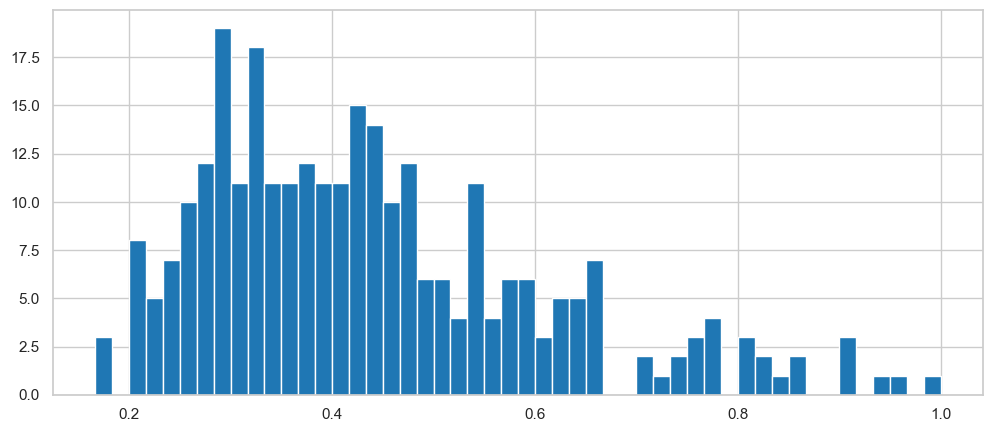

In [260]:
suburb_means.price_mean_proportion.hist(bins=50)

In [261]:
train_set_processed = set_price_mean_proportions(train_set_processed, suburb_means, 'Suburb')
valid_set_processed = set_price_mean_proportions(valid_set_processed, suburb_means, 'Suburb')
test_set_processed = set_price_mean_proportions(test_set_processed, suburb_means, 'Suburb')

In [262]:
# And remove the SellerG that will no longer be used
train_set_processed.drop(['Suburb'], axis=1, inplace=True)
valid_set_processed.drop(['Suburb'], axis=1, inplace=True)
test_set_processed.drop(['Suburb'], axis=1, inplace=True)

### Council Area

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_92453/2600807695.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = df\


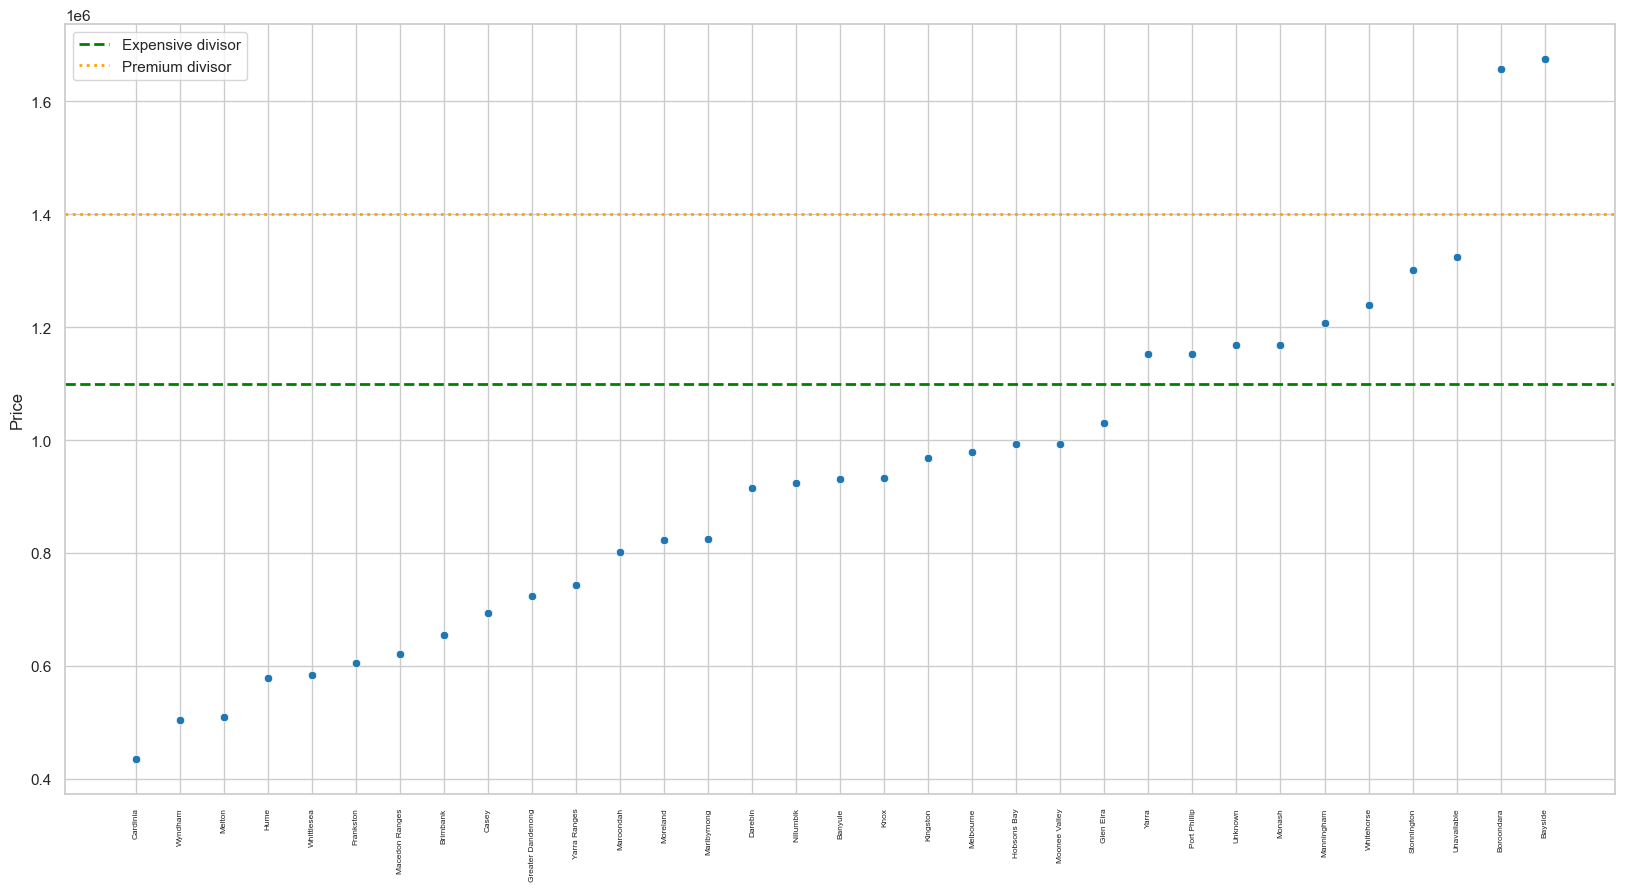

In [263]:
council_pricing, _ = plot_distribution_grouped_field(
    train_set_processed, 
    'CouncilArea', 
    expensive_divisor=1.1e6, 
    premium_divisor=1.4e6
)

In [264]:
train_set_processed = classify_category(
    df=train_set_processed,
    group_pricing=council_pricing,
    input_column_name='CouncilArea',
    output_column_name='council_class',
    premium_threshold=1e6,
    expensive_threshold=1.3e6,
)

valid_set_processed = classify_category(
    df=valid_set_processed,
    group_pricing=council_pricing,
    input_column_name='CouncilArea',
    output_column_name='council_class',
    premium_threshold=1e6,
    expensive_threshold=1.3e6,
)

test_set_processed = classify_category(
    df=test_set_processed,
    group_pricing=council_pricing,
    input_column_name='CouncilArea',
    output_column_name='council_class',
    premium_threshold=1e6,
    expensive_threshold=1.3e6,
)

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_92453/4093301365.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_means = pd.DataFrame(df\


<AxesSubplot:>

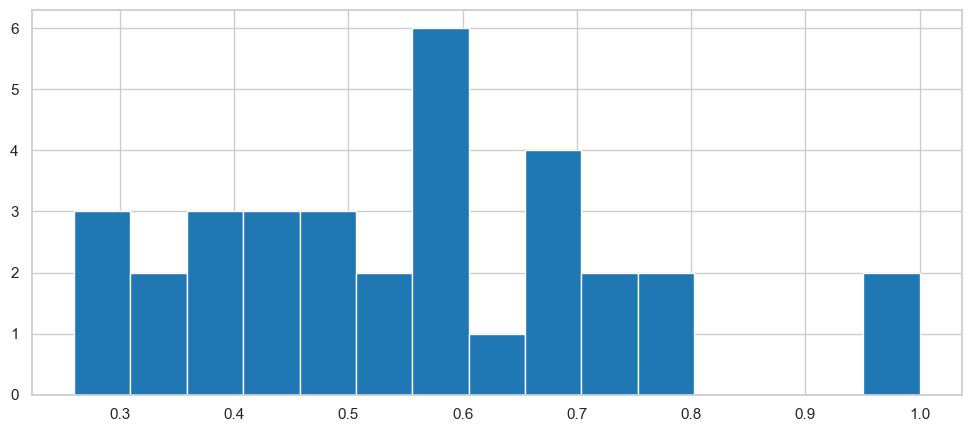

In [265]:
# TODO: Both mean, median and for log prices as well
council_means = get_scoring_mean_price(train_set_processed, 'CouncilArea')
council_means.price_mean_proportion.hist(bins=15)

In [266]:
train_set_processed = set_price_mean_proportions(train_set_processed, council_means, 'CouncilArea')
valid_set_processed = set_price_mean_proportions(valid_set_processed, council_means, 'CouncilArea')
test_set_processed = set_price_mean_proportions(test_set_processed, council_means, 'CouncilArea')

In [267]:
train_set_processed.drop(['CouncilArea'], axis=1, inplace=True)
valid_set_processed.drop(['CouncilArea'], axis=1, inplace=True)
test_set_processed.drop(['CouncilArea'], axis=1, inplace=True)

### Address

There are a lof of different addresses.
We could check for the case of some has been re-sold.

In [268]:
def add_feature_resold(
    data_duplicated: pd.DataFrame, 
    data_source: pd.DataFrame
):
    
    before, actual = '', ''
    for idx, row in data_duplicated.iterrows():
        if not before:
            before = row['Address']
            data_source.loc[idx, 'Resold'] = 0
            continue

        actual = row['Address']
        if before == actual:
            # Set it directly this new feature on extended dataframe
            data_source.loc[idx, 'Resold'] = 1

        else:
            data_source.loc[idx, 'Resold'] = 0
            before = actual
    
    return data_source

def check_resold_houses(data: pd.DataFrame):
    # Will assume that the ones with same values in address, room, bedroom and bathroom is the same house being sold
    multiple_sold = data[
        data.duplicated(
            subset=['Address', 'Rooms', 'Bedroom2', 'Bathroom'], 
            keep=False
        )
    ].sort_values(['Address', 'Date'])
    
    # And now we add the feature of being sold
    if len(multiple_sold) > 0:
        data = add_feature_resold(multiple_sold, data)
        data['Resold'] = data['Resold'].fillna(0).astype('int8')
    else:
        data['Resold'] = 0
    
    # An example with the ones sold more than once
    display(data.loc[multiple_sold.index].head(2))
    
    address_feature = ['Resold']
    
    return data, address_feature

In [269]:
train_set_processed, _ = check_resold_houses(train_set_processed)
valid_set_processed, _ = check_resold_houses(valid_set_processed)
test_set_processed, _ = check_resold_houses(test_set_processed)

,Address,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,Price_log,seller_class,sellerg_price_mean_prop,suburb_class,suburb_price_mean_prop,council_class,councilarea_price_mean_prop,Resold
index,,,,,,,,,,,,,,,,,,,,,,,,,,
2564,1/26 York St,3,t,595000.0,SP,20/05/2017,13.0,3046.0,3.0,1.0,2.0,258.0,142.6,2001.0,-37.7047,144.9087,Northern Metropolitan,8870.0,13.296317,0.0,0.125788,0.0,0.327856,0.0,0.492235,0
3470,1/26 York St,3,t,600000.0,VB,27/11/2016,13.0,3046.0,3.0,1.0,2.0,258.0,143.0,2001.0,-37.7047,144.9087,Northern Metropolitan,8870.0,13.304685,0.0,0.125788,0.0,0.327856,0.0,0.492235,1


,Address,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,seller_class,sellerg_price_mean_prop,suburb_class,suburb_price_mean_prop,council_class,councilarea_price_mean_prop,Resold
index,,,,,,,,,,,,,,,,,,,,,,,,,


,Address,Rooms,Type,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,seller_class,sellerg_price_mean_prop,suburb_class,suburb_price_mean_prop,council_class,councilarea_price_mean_prop,Resold
index,,,,,,,,,,,,,,,,,,,,,,,,
2968,1 Daisy St,4,h,S,3/06/2017,7.5,3040.0,4.0,2.0,1.0,267.0,191.696607,1983.043279,-37.75472,144.92723,Western Metropolitan,9264.0,0.0,0.171917,0.0,0.493054,0.0,0.593663,0
5166,1 Daisy St,4,h,VB,8/04/2017,8.0,3040.0,4.0,2.0,1.0,267.0,191.696607,1983.043279,-37.75580,144.91060,Western Metropolitan,9264.0,0.0,0.125788,0.0,0.493054,0.0,0.593663,1


In [270]:
train_set_processed.drop(['Address'], axis=1, inplace=True)
valid_set_processed.drop(['Address'], axis=1, inplace=True)
test_set_processed.drop(['Address'], axis=1, inplace=True)

### Type, Regionname & Method

Simply creating one-hot encoding for them.

In [271]:
train_set_processed = pd.get_dummies(
    train_set_processed, 
    columns=['Method'], 
    drop_first=True
)

valid_set_processed = pd.get_dummies(
    valid_set_processed, 
    columns=['Method'], 
    drop_first=True
)

test_set_processed = pd.get_dummies(
    test_set_processed, 
    columns=['Method'], 
    drop_first=True
)

In [272]:
train_set_processed = pd.get_dummies(
    train_set_processed, 
    columns=['Type'], 
    drop_first=True
)

valid_set_processed = pd.get_dummies(
    valid_set_processed, 
    columns=['Type'], 
    drop_first=True
)

test_set_processed = pd.get_dummies(
    test_set_processed, 
    columns=['Type'], 
    drop_first=True
)

In [273]:
train_set_processed = pd.get_dummies(
    train_set_processed, 
    columns=['Regionname'], 
    drop_first=True
)

valid_set_processed = pd.get_dummies(
    valid_set_processed, 
    columns=['Regionname'], 
    drop_first=True
)

test_set_processed = pd.get_dummies(
    test_set_processed, 
    columns=['Regionname'], 
    drop_first=True
)

### Postcode & Date

Postcode is a categorical variable, as the numbers does not have an order. So we will remove that one.

For date, we will extract the date in which it was sold and the difference.

In [274]:
train_set_processed.head(3)

,Rooms,Price,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Price_log,seller_class,sellerg_price_mean_prop,suburb_class,suburb_price_mean_prop,council_class,councilarea_price_mean_prop,Resold,Method_S,Method_SA,Method_SP,Method_VB,Type_t,Type_u,Regionname_Northern Metropolitan,Regionname_Other,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1845,2,765000.0,10/12/2016,4.2,3031.0,2.0,1.0,2.0,158.0,76.000000,1965.000000,-37.79020,144.93190,5263.0,13.547631,0.0,0.095625,0.0,0.394697,0.0,0.584455,0,1,0,0,0,0,0,1,0,0,0,0
828,2,1500000.0,15/07/2017,13.4,3130.0,2.0,1.0,1.0,1021.0,83.389149,1971.243876,-37.83189,145.15785,5713.0,14.220976,0.0,0.152119,0.0,0.615228,0.0,0.740525,0,1,0,0,0,0,0,0,0,0,0,0
973,3,485000.0,12/11/2016,8.8,3072.0,3.0,1.0,1.0,244.0,117.473722,1971.243876,-37.74440,145.02020,14577.0,13.091904,0.0,0.105776,0.0,0.425343,0.0,0.546860,0,0,0,0,0,0,0,1,0,0,0,0


In [275]:
# Dropping postcodes
train_set_processed.drop(['Postcode'], axis=1, inplace=True)
valid_set_processed.drop(['Postcode'], axis=1, inplace=True)
test_set_processed.drop(['Postcode'], axis=1, inplace=True)

In [276]:
train_set_processed['year_sold'] = pd.to_datetime(train_set_processed['Date']).dt.year
valid_set_processed['year_sold'] = pd.to_datetime(valid_set_processed['Date']).dt.year
test_set_processed['year_sold'] = pd.to_datetime(test_set_processed['Date']).dt.year

In [277]:
train_set_processed['years_to_sell'] = train_set_processed['year_sold'] - train_set_processed['YearBuilt']
valid_set_processed['years_to_sell'] = valid_set_processed['year_sold'] - valid_set_processed['YearBuilt']
test_set_processed['years_to_sell'] = test_set_processed['year_sold'] - test_set_processed['YearBuilt']

In [278]:
# Dropping date
train_set_processed.drop(['Date'], axis=1, inplace=True)
valid_set_processed.drop(['Date'], axis=1, inplace=True)
test_set_processed.drop(['Date'], axis=1, inplace=True)

# Feature Engineering

Apart from the features we already created, we are going to add some more.

In [279]:
train_set_extended = train_set_processed.copy()
valid_set_extended = valid_set_processed.copy()
test_set_extended = test_set_processed.copy()

### Ratios

In [280]:
train_set_extended

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Price_log,seller_class,sellerg_price_mean_prop,suburb_class,suburb_price_mean_prop,council_class,councilarea_price_mean_prop,Resold,Method_S,Method_SA,Method_SP,Method_VB,Type_t,Type_u,Regionname_Northern Metropolitan,Regionname_Other,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,year_sold,years_to_sell
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1845,2,765000.0,4.2,2.0,1.0,2.0,158.0,76.000000,1965.000000,-37.79020,144.93190,5263.0,13.547631,0.0,0.095625,0.0,0.394697,0.0,0.584455,0,1,0,0,0,0,0,1,0,0,0,0,2016,51.000000
828,2,1500000.0,13.4,2.0,1.0,1.0,1021.0,83.389149,1971.243876,-37.83189,145.15785,5713.0,14.220976,0.0,0.152119,0.0,0.615228,0.0,0.740525,0,1,0,0,0,0,0,0,0,0,0,0,2017,45.756124
973,3,485000.0,8.8,3.0,1.0,1.0,244.0,117.473722,1971.243876,-37.74440,145.02020,14577.0,13.091904,0.0,0.105776,0.0,0.425343,0.0,0.546860,0,0,0,0,0,0,0,1,0,0,0,0,2016,44.756124
1964,3,1760000.0,1.6,3.0,2.0,2.0,151.0,147.723193,1994.920046,-37.79449,144.97406,6786.0,14.380824,0.0,0.125788,0.0,0.462485,0.0,0.584455,0,1,0,0,0,0,0,1,0,0,0,0,2017,22.079954
1609,5,2500000.0,7.5,5.0,3.0,0.0,757.0,240.000000,1925.000000,-37.81760,145.05480,6482.0,14.731801,1.0,0.197631,1.0,0.707542,2.0,0.990030,0,0,0,0,1,0,0,0,0,0,1,0,2016,91.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,3,1470000.0,1.6,3.0,2.0,2.0,326.5,147.723193,1994.920046,-37.80370,144.98460,4553.0,14.200773,0.0,0.125788,0.0,0.427381,0.0,0.688045,0,1,0,0,0,0,1,1,0,0,0,0,2016,21.079954
222,3,300000.0,29.8,3.0,1.0,1.0,585.0,117.473722,1971.243876,-37.71195,144.57235,4718.0,12.611538,0.0,0.062133,0.0,0.172576,0.0,0.304297,0,1,0,0,0,0,0,0,1,0,0,0,2017,45.756124
2825,3,538000.0,12.4,3.0,2.0,2.0,217.0,147.723193,1994.920046,-37.70180,144.96790,5070.0,13.195614,0.0,0.067250,0.0,0.306035,0.0,0.492235,0,1,0,0,0,1,0,1,0,0,0,0,2016,21.079954


In [281]:
# Adding ratios
train_set_extended['bed_bath_ratio'] = train_set_extended['Bedroom2'] + 1 / train_set_extended['Bathroom'] + 1
train_set_extended['car_bed_ratio'] = train_set_extended['Car'] + 1/ train_set_extended['Bedroom2'] + 1
train_set_extended['bed_room_ratio'] = train_set_extended['Bedroom2'] + 1 / train_set_extended['Rooms'] + 1
train_set_extended['bath_room_ratio'] = train_set_extended['Bathroom'] + 1 / train_set_extended['Rooms'] + 1
train_set_extended['room_building_area_ratio'] = train_set_extended['Rooms'] + 1 / train_set_extended['BuildingArea'] + 1
train_set_extended['bed_building_area_ratio'] = train_set_extended['Bedroom2'] + 1 / train_set_extended['BuildingArea'] + 1
train_set_extended['bath_building_area_ratio'] = train_set_extended['Bathroom'] + 1 / train_set_extended['BuildingArea'] + 1


valid_set_extended['bed_bath_ratio'] = valid_set_extended['Bedroom2'] + 1 / valid_set_extended['Bathroom'] + 1
valid_set_extended['car_bed_ratio'] = valid_set_extended['Car'] + 1/ valid_set_extended['Bedroom2'] + 1
valid_set_extended['bed_room_ratio'] = valid_set_extended['Bedroom2'] + 1 / valid_set_extended['Rooms'] + 1
valid_set_extended['bath_room_ratio'] = valid_set_extended['Bathroom'] + 1 / valid_set_extended['Rooms'] + 1
valid_set_extended['room_building_area_ratio'] = valid_set_extended['Rooms'] + 1 / valid_set_extended['BuildingArea'] + 1
valid_set_extended['bed_building_area_ratio'] = valid_set_extended['Bedroom2'] + 1 / valid_set_extended['BuildingArea'] + 1
valid_set_extended['bath_building_area_ratio'] = valid_set_extended['Bathroom'] + 1 / valid_set_extended['BuildingArea'] + 1


test_set_extended['bed_bath_ratio'] = test_set_extended['Bedroom2'] + 1 / test_set_extended['Bathroom'] + 1
test_set_extended['car_bed_ratio'] = test_set_extended['Car'] + 1/ test_set_extended['Bedroom2'] + 1
test_set_extended['bed_room_ratio'] = test_set_extended['Bedroom2'] + 1 / test_set_extended['Rooms'] + 1
test_set_extended['bath_room_ratio'] = test_set_extended['Bathroom'] + 1 / test_set_extended['Rooms'] + 1
test_set_extended['room_building_area_ratio'] = test_set_extended['Rooms'] + 1 / test_set_extended['BuildingArea'] + 1
test_set_extended['bed_building_area_ratio'] = test_set_extended['Bedroom2'] + 1 / test_set_extended['BuildingArea'] + 1
test_set_extended['bath_building_area_ratio'] = test_set_extended['Bathroom'] + 1 / test_set_extended['BuildingArea'] + 1

### Logs & Sqrt

In [282]:
# Adding the logarithms
train_set_extended = create_logs(train_set_extended)
valid_set_extended = create_logs(valid_set_extended)
test_set_extended = create_logs(test_set_extended)

In [283]:
train_set_extended['Price_log'] = np.log(train_set_extended.Price + 1)
valid_set_extended['Price_log'] = np.log(valid_set_extended.Price + 1)

In [284]:
train_set_extended['Distance_sqr'] = np.sqrt(train_set_extended['Distance'])
train_set_extended['Landsize_sqr'] = np.sqrt(train_set_extended['Landsize'])
train_set_extended['BuildingArea_sqr'] = np.sqrt(train_set_extended['BuildingArea'])
train_set_extended['Propertycount_sqr'] = np.sqrt(train_set_extended['Propertycount'])

valid_set_extended['Distance_sqr'] = np.sqrt(valid_set_extended['Distance'])
valid_set_extended['Landsize_sqr'] = np.sqrt(valid_set_extended['Landsize'])
valid_set_extended['BuildingArea_sqr'] = np.sqrt(valid_set_extended['BuildingArea'])
valid_set_extended['Propertycount_sqr'] = np.sqrt(valid_set_extended['Propertycount'])

test_set_extended['Distance_sqr'] = np.sqrt(test_set_extended['Distance'])
test_set_extended['Landsize_sqr'] = np.sqrt(test_set_extended['Landsize'])
test_set_extended['BuildingArea_sqr'] = np.sqrt(test_set_extended['BuildingArea'])
test_set_extended['Propertycount_sqr'] = np.sqrt(test_set_extended['Propertycount'])

### Property Count

Will bucketize also this feature.

In [285]:
# Create buckets of property count
_, pc_bins = pd.qcut(train_set_extended['Propertycount'], 9, labels=False, retbins=True)

train_set_extended['prop_count_bkt'] = pd.cut(
    train_set_extended['Propertycount'], 
    bins=pc_bins, 
    labels=range(len(pc_bins)-1),
    include_lowest=True
)

valid_set_extended['prop_count_bkt'] = pd.cut(
    valid_set_extended['Propertycount'], 
    bins=pc_bins, 
    labels=range(len(pc_bins)-1),
    include_lowest=True
)

test_set_extended['prop_count_bkt'] = pd.cut(
    test_set_extended['Propertycount'], 
    bins=pc_bins, 
    labels=range(len(pc_bins)-1),
    include_lowest=True
)
test_set_extended['prop_count_bkt'].fillna(0.0, inplace=True) # one of 250

### Longtitude & Lattitude

Will assume that there are groups for that location that are of relevent importance for the price.

In [286]:
train_long_lat = train_set_extended[['Longtitude', 'Lattitude']]
valid_long_lat = valid_set_extended[['Longtitude', 'Lattitude']]
test_long_lat = test_set_extended[['Longtitude', 'Lattitude']]

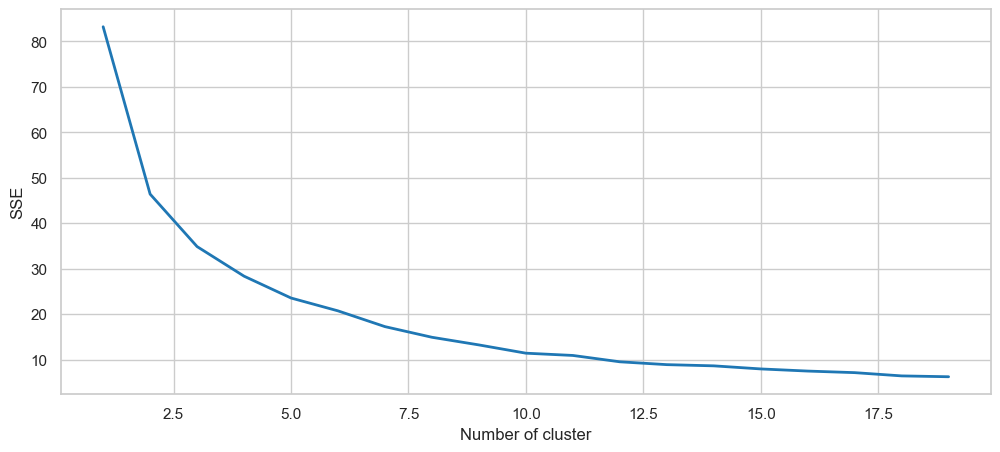

In [287]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(
        n_clusters=k, 
        max_iter=1000, 
        n_init='auto'
    ).fit(train_long_lat)
        
    # Squarred Sum of Errors
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [288]:
divisor = 12
n_features = math.floor((train_set['YearBuilt'].nunique() / divisor))

print('Number of features: ', n_features)
k_means = KMeans(
    n_clusters=n_features, 
    n_init='auto',
    max_iter=1000
)

k_means.fit(train_long_lat)

Number of features:  9


KMeans(max_iter=1000, n_clusters=9, n_init='auto')

In [289]:
# With the same model trained we predict both groups for test & trian
labels_train = k_means.labels_
labels_valid = k_means.predict(valid_long_lat)
labels_test = k_means.predict(test_long_lat)

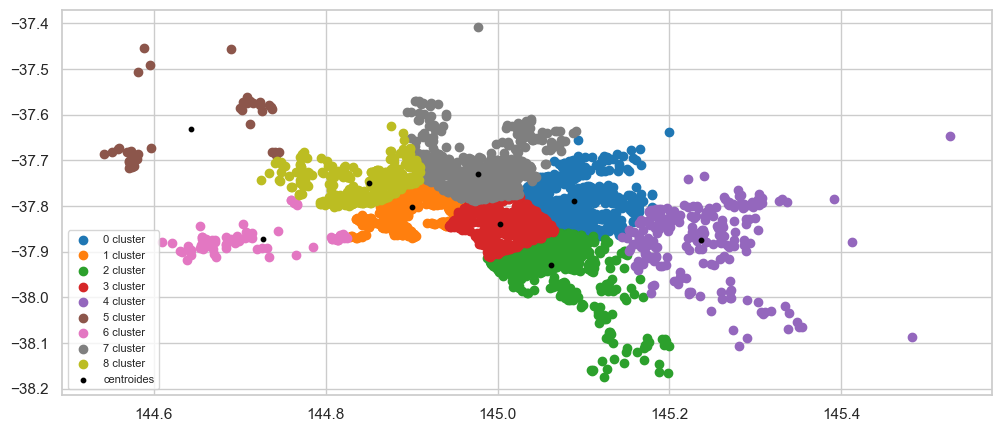

In [290]:
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

unique_labels = np.unique(labels_train)
 
for label in unique_labels:
    plt.scatter(
        train_long_lat.iloc[labels_train == label, 0], 
        train_long_lat.iloc[labels_train == label, 1], 
        label = f"{label} cluster",
    )

plt.scatter(
    centroides[:,0],
    centroides[:,1], 
    label='centroides', 
    color = 'k', 
    s=10
)

plt.legend(
    prop={'size': 8}
)
plt.show()

In [361]:
# Add this new feature into the dataframe
train_set_extended['location_group'] = labels_train
valid_set_extended['location_group'] = labels_valid
test_set_extended['location_group'] = labels_test

In [320]:
# train_set_extended['location_group'] = train_set_extended['location_group'].astype('category')
# valid_set_extended['location_group'] = valid_set_extended['location_group'].astype('category')
# test_set_extended['location_group'] = test_set_extended['location_group'].astype('category')

Having those clusters identified can be interesting for then to see distribution of the prices in each one. And letting a model to have a value for which to pivot -/+ with respect to make the prediction.

Will also create another cluster for the ones that have price in the 95th percentile or more

In [356]:
# The 9th cluster  -> for prediction of prices
percentile_price_train = train_set_extended.Price.quantile(.999)
round(percentile_price_train, 2)

5220336.0

<AxesSubplot:>

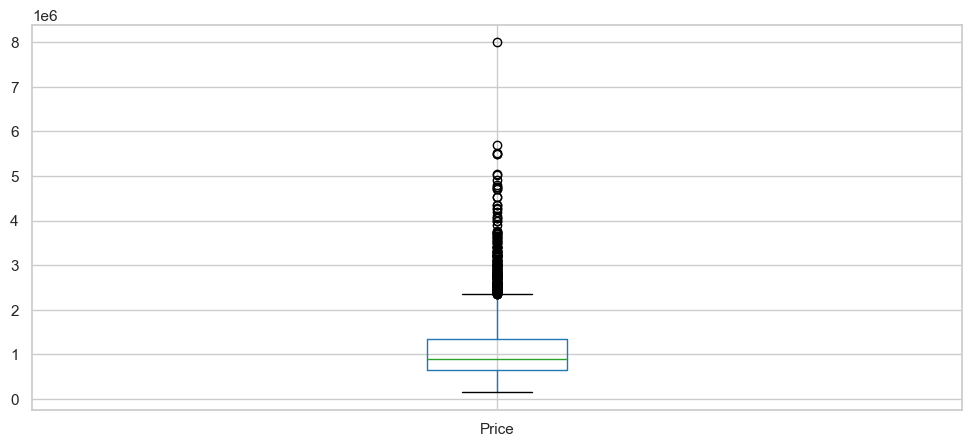

In [357]:
pd.DataFrame(train_set_extended.Price).boxplot()

In [358]:
"""train_set_extended.loc[
    (train_set_extended.Price > percentile_price_train).values,
    'location_group'
] = 9"""

For now, for each of the known clusters we will impute which is the mean/median in each of their locations, and divide by the max in each of their respective locations.

In [376]:
location_group_info = train_set_extended\
    .groupby('location_group')[['Price', 'Price_log']]\
    .describe().T

location_group_info

location_group              0             1             2             3  \
Price     count  7.130000e+02  6.530000e+02  6.850000e+02  9.080000e+02   
          mean   1.372110e+06  9.835506e+05  1.234673e+06  1.256390e+06   
          std    7.661341e+05  4.483184e+05  6.008802e+05  8.762708e+05   
          min    3.200000e+05  1.850000e+05  2.565000e+05  1.600000e+05   
          25%    8.130000e+05  6.830000e+05  8.160000e+05  6.000000e+05   
          50%    1.240000e+06  9.200000e+05  1.150000e+06  1.004000e+06   
          75%    1.690000e+06  1.230000e+06  1.570000e+06  1.626250e+06   
          max    8.000000e+06  3.400000e+06  4.700000e+06  5.700000e+06   
Price_log count  7.130000e+02  6.530000e+02  6.850000e+02  9.080000e+02   
          mean   1.400155e+01  1.369326e+01  1.390873e+01  1.383346e+01   
          std    5.048541e-01  4.749826e-01  5.002155e-01  6.461090e-01   
          min    1.267608e+01  1.212812e+01  1.245489e+01  1.198294e+01   
          25%    1.360849e+01  1.343425e+01  1.361217e+01  1.330469e+01   
          50%    1.403062e+01  1.373213e+01  1.395527e+01  1.381950e+01   
          75%    1.434024e+01  1.402253e+01  1.426659e+01  1.430179e+01   
          max    1.589495e+01  1.503929e+01  1.536307e+01  1.555598e+01   

location_group              4             5             6             7  \
Price     count  2.130000e+02  4.400000e+01  8.300000e+01  9.070000e+02   
          mean   9.412695e+05  5.247523e+05  6.284795e+05  8.624168e+05   
          std    3.488172e+05  1.939735e+05  2.653398e+05  3.884454e+05   
          min    3.480000e+05  3.000000e+05  3.150000e+05  1.450000e+05   
          25%    7.000000e+05  3.987500e+05  4.812500e+05  6.000000e+05   
          50%    8.700000e+05  4.575000e+05  5.400000e+05  8.000000e+05   
          75%    1.120000e+06  6.083375e+05  6.850000e+05  1.030000e+06   
          max    3.056000e+06  1.355000e+06  1.780000e+06  2.990000e+06   
Price_log count  2.130000e+02  4.400000e+01  8.300000e+01  9.070000e+02   
          mean   1.369647e+01  1.311820e+01  1.328663e+01  1.357351e+01   
          std    3.359606e-01  3.128490e-01  3.388247e-01  4.357526e-01   
          min    1.275996e+01  1.261154e+01  1.266033e+01  1.188450e+01   
          25%    1.345884e+01  1.289608e+01  1.308414e+01  1.330469e+01   
          50%    1.367625e+01  1.303352e+01  1.319933e+01  1.359237e+01   
          75%    1.392884e+01  1.331844e+01  1.343715e+01  1.384507e+01   
          max    1.493262e+01  1.411931e+01  1.439212e+01  1.491078e+01   

location_group              8  
Price     count  4.110000e+02  
          mean   7.644766e+05  
          std    2.743977e+05  
          min    2.450000e+05  
          25%    5.930000e+05  
          50%    7.070000e+05  
          75%    8.595000e+05  
          max    2.400000e+06  
Price_log count  4.110000e+02  
          mean   1.349333e+01  
          std    3.203421e-01  
          min    1.240902e+01  
          25%    1.329295e+01  
          50%    1.346879e+01  
          75%    1.366411e+01  
          max    1.469098e+01

In [384]:
location_means = get_scoring_mean_price(train_set_extended, 'location_group')

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_92453/4093301365.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_means = pd.DataFrame(df\


### Sum Up of Variables

In [293]:
print(train_set_extended.dtypes.to_string())

Rooms                                       int64
Price                                     float64
Distance                                  float64
Bedroom2                                  float64
Bathroom                                  float64
Car                                       float64
Landsize                                  float64
BuildingArea                              float64
YearBuilt                                 float64
Lattitude                                 float64
Longtitude                                float64
Propertycount                             float64
Price_log                                 float64
seller_class                              float64
sellerg_price_mean_prop                   float64
suburb_class                              float64
suburb_price_mean_prop                    float64
council_class                             float64
councilarea_price_mean_prop               float64
Resold                                       int8


In [294]:
train_set_extended.isin([-np.inf, np.inf]).sum().sum()

0

# Model Creation: Price Log

In [295]:
train_set_final = train_set_extended.copy()
valid_set_final = valid_set_extended.copy()
test_set_final = test_set_extended.copy()

In [119]:
pd.set_option('display.max_rows', 500)

corr_final = train_set_final.corr().sort_values('Price')[['Price', 'Price_log']]
corr_final

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_92453/803969539.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_final = train_set_final.corr().sort_values('Price')[['Price', 'Price_log']]


,Price,Price_log
Type_u,-0.386761,-0.506826
Lattitude,-0.204988,-0.216350
YearBuilt_log,-0.194843,-0.215503
YearBuilt,-0.193477,-0.214092
Regionname_Western Metropolitan,-0.176281,-0.167577
Distance,-0.174566,-0.167657
Regionname_Northern Metropolitan,-0.162253,-0.155691
Distance_sqr,-0.162167,-0.150693
Method_SP,-0.090896,-0.097690
Regionname_Other,-0.079703,-0.105316


<AxesSubplot:>

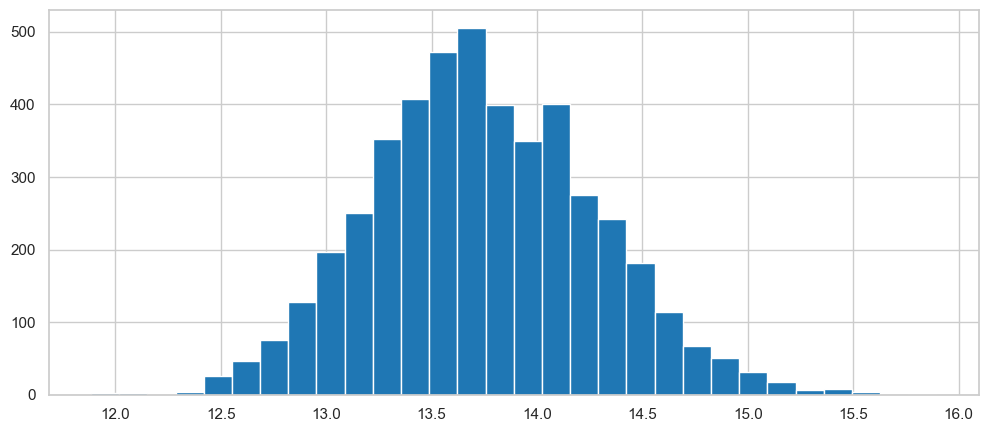

In [120]:
# More like a normal distribution
train_set_final.Price_log.hist(bins=30)

So we can see it could be easier to predict which is the logarithm of the price, and then afterwards we make the change.

In [121]:
# Extract features with corr > 10
final_features = corr_final[(corr_final.Price_log > .1) | (corr_final.Price_log < -.1)].index.values
final_features = [feature for feature in final_features if feature not in ['Price', 'Price_log']]
final_features

['Type_u',
 'Lattitude',
 'YearBuilt_log',
 'YearBuilt',
 'Regionname_Western Metropolitan',
 'Distance',
 'Regionname_Northern Metropolitan',
 'Distance_sqr',
 'Regionname_Other',
 'Landsize_sqr',
 'Landsize_log',
 'years_to_sell',
 'Longtitude',
 'Regionname_Southern Metropolitan',
 'council_class',
 'BuildingArea_sqr',
 'bed_bath_ratio',
 'bath_room_ratio',
 'seller_class',
 'councilarea_price_mean_prop',
 'bed_room_ratio',
 'Bathroom_log',
 'Bedroom2_log',
 'bed_building_area_ratio',
 'Bedroom2',
 'bath_building_area_ratio',
 'Bathroom',
 'suburb_class',
 'BuildingArea_log',
 'Rooms_log',
 'room_building_area_ratio',
 'Rooms',
 'sellerg_price_mean_prop',
 'suburb_price_mean_prop']

In [122]:
# Will add categorical that were not considered before
final_features += ['prop_count_bkt', 'location_group']

In [123]:
# We will standarize those features
final_scaler = StandardScaler()

Y_train_set_final = train_set_final.Price_log.ravel().reshape(-1, 1)
X_train_set_final = train_set_final[final_features]

Y_valid_set_final = valid_set_final.Price_log.ravel().reshape(-1, 1)
X_valid_set_final = valid_set_final[final_features]

X_test_set_final = test_set_final[final_features]

X_train_set_final = final_scaler.fit_transform(X_train_set_final)
X_valid_set_final = final_scaler.transform(X_valid_set_final)
X_test_set_final = final_scaler.transform(X_test_set_final)

As requested in the problem, use LR or KNNeighbors.

### Linear Regressor

Can try different linear models.

In [124]:
lr_final_model = LinearRegression().fit(X_train_set_final, Y_train_set_final)

lr_pred = np.exp(lr_final_model.predict(X_valid_set_final))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final)))

Mean Squarred Error 353515.3269436599
Mean Absolute Error 207783.68843909283
R2 Score 0.548331070789086


In [125]:
lr_final_model = HuberRegressor().fit(X_train_set_final, Y_train_set_final)

lr_pred = np.exp(lr_final_model.predict(X_valid_set_final))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final)))

Mean Squarred Error 355128.0897173795
Mean Absolute Error 209671.64897837865
R2 Score 0.5453114345548572


In [126]:
lr_final_model = Lasso().fit(X_train_set_final, Y_train_set_final)

lr_pred = np.exp(lr_final_model.predict(X_valid_set_final))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final)))

Mean Squarred Error 671963.9281439251
Mean Absolute Error 443622.2970192152
R2 Score -3.701937862681346e+30


In [127]:
lr_final_model = Ridge().fit(X_train_set_final, Y_train_set_final)

lr_pred = np.exp(lr_final_model.predict(X_valid_set_final))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final)))

Mean Squarred Error 355077.8968061494
Mean Absolute Error 209425.40139143786
R2 Score 0.5429423693362907


In [128]:
lr_final_model = RANSACRegressor(random_state=42).fit(X_train_set_final, Y_train_set_final)

lr_pred = np.exp(lr_final_model.predict(X_valid_set_final))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final)))

Mean Squarred Error 1.1678445407924429e+20
Mean Absolute Error 4.0909095469895864e+18
R2 Score -0.001228578530154234


In [129]:
lr_final_model = TheilSenRegressor(random_state=42).fit(X_train_set_final, Y_train_set_final)

lr_pred = np.exp(lr_final_model.predict(X_valid_set_final))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final)))

Mean Squarred Error 504416.2192271933
Mean Absolute Error 271856.50336532027
R2 Score -0.5505962873037178


In [130]:
# Seems th best one is the Linear one, but it is more propense to outliers. Will go for Hubber
from sklearn.model_selection import cross_val_score
lr_scores = cross_val_score(
    RANSACRegressor(random_state=42).fit(X_train_set_final, Y_train_set_final),
    X_train_set_final, Y_train_set_final,
    scoring='neg_root_mean_squared_error',
    cv=10
)

In [132]:
# Not very significant, as we should be in exponential of the predictions
np.sqrt(-lr_scores.mean()), np.sqrt(lr_scores.std())

(311754.1674925316, 456584.2873066152)

## Decision Tree

In [133]:
dt_final_model = DecisionTreeRegressor(random_state=42).fit(X_train_set_final, Y_train_set_final)

In [134]:
dt_pred = np.exp(dt_final_model.predict(X_valid_set_final))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final)))

Mean Squarred Error 504416.2192271933
Mean Absolute Error 271856.50336532027


In [135]:
# So we can see a huge overfitting
print(mean_squared_error(np.exp(dt_final_model.predict(X_train_set_final)), np.exp(Y_train_set_final), squared=False))
print(mean_squared_error(np.exp(dt_final_model.predict(X_valid_set_final)), np.exp(Y_valid_set_final), squared=False))

1862.827904687364
399875.2631058472


In [136]:
# Can try search to not overfit
space_dt = { 
    'max_depth': [12, 15, 20, 25],
    'min_samples_leaf': [16, 20],
    'min_samples_split': [30, 40],
    'max_features': [8, 10, 12],
}

# Want to be very precise
scoring = ['neg_mean_squared_error']
search_model_dt = DecisionTreeRegressor()

grid_search_final_dt = GridSearchCV(
    estimator=search_model_dt,
    param_grid=space_dt, 
    scoring=scoring, 
    n_jobs=-1, 
    refit=scoring[0],
    cv=3, 
    verbose=-1,
)

grid_search_final_dt.fit(X_train_set_final, Y_train_set_final)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [12, 15, 20, 25],
                         'max_features': [8, 10, 12],
                         'min_samples_leaf': [16, 20],
                         'min_samples_split': [30, 40]},
             refit='neg_mean_squared_error', scoring=['neg_mean_squared_error'],
             verbose=-1)

In [137]:
grid_search_final_dt.best_estimator_

DecisionTreeRegressor(max_depth=25, max_features=12, min_samples_leaf=20,
                      min_samples_split=40)

In [138]:
mean_squared_error(np.exp(grid_search_final_dt.predict(X_train_set_final)), np.exp(Y_train_set_final), squared=False)

318114.1609619077

In [139]:
mean_squared_error(np.exp(grid_search_final_dt.predict(X_valid_set_final)), np.exp(Y_valid_set_final), squared=False)

346270.9217084481

## Random Forest

TODO: Create feature importances based on the tree, and try to use those values (not the ones with corr, as those are for assuming linear relationship)

In [140]:
# Can try search to not overfit
space_rf = { 
    'n_estimators': [30, 60, 80, 100],
    'max_depth': [3, 4, 6, 8, 10, 12],
    'min_samples_leaf': [18, 20],
    'min_samples_split': [30, 40],
    'max_features': [4, 6, 8, 10, 12],
}

# Want to be very precise
scoring = ['neg_mean_squared_error']
search_model_rf = RandomForestRegressor()

grid_search_final_rf = GridSearchCV(
    estimator=search_model_rf,
    param_grid=space_rf, 
    scoring=scoring, 
    n_jobs=-1, 
    refit=scoring[0],
    cv=3, 
    verbose=-1,
)

grid_search_final_rf.fit(X_train_set_final, Y_train_set_final)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 6, 8, 10, 12],
                         'max_features': [4, 6, 8, 10, 12],
                         'min_samples_leaf': [18, 20],
                         'min_samples_split': [30, 40],
                         'n_estimators': [30, 60, 80, 100]},
             refit='neg_mean_squared_error', scoring=['neg_mean_squared_error'],
             verbose=-1)

In [141]:
grid_search_final_rf.best_estimator_

RandomForestRegressor(max_depth=12, max_features=12, min_samples_leaf=18,
                      min_samples_split=30, n_estimators=30)

In [142]:
grid_search_final_rf.best_params_

{'max_depth': 12,
 'max_features': 12,
 'min_samples_leaf': 18,
 'min_samples_split': 30,
 'n_estimators': 30}

In [143]:
{**grid_search_final_rf.best_params_, 'max_depth': 14}

{'max_depth': 14,
 'max_features': 12,
 'min_samples_leaf': 18,
 'min_samples_split': 30,
 'n_estimators': 30}

In [144]:
best_hp = {**grid_search_final_rf.best_params_, 'max_depth': 14, 'n_estimators': 80, 'max_features': 14}
best_model = RandomForestRegressor(**{key: int(value) for key, value in best_hp.items()}).fit(X_train_set_final, Y_train_set_final)

print(mean_squared_error(np.exp(best_model.predict(X_train_set_final)), np.exp(Y_train_set_final), squared=False))
print(mean_squared_error(np.exp(best_model.predict(X_valid_set_final)), np.exp(Y_valid_set_final), squared=False))

297696.05797839223
324598.3030965115


In [145]:
mean_squared_error(np.exp(grid_search_final_rf.predict(X_train_set_final)), np.exp(Y_train_set_final), squared=False)

301628.9386060595

In [146]:
mean_squared_error(np.exp(grid_search_final_rf.predict(X_valid_set_final)), np.exp(Y_valid_set_final), squared=False)

328793.0034378451

Best so far: 331276.7979632767, and in train 312422.0375526496.

{'max_depth': 12,
 'max_features': 10,
 'min_samples_leaf': 18,
 'min_samples_split': 30,
 'n_estimators': 60}



### XGBoost

In [147]:
import xgboost as xgb

First, we will do feature selection to reduce amount of variance that the model can use.

In [148]:
# TODO: Train with all variables, then feature selection, and try again
xgb_final_model = xgb.XGBRegressor().fit(X_train_set_final, Y_train_set_final)

In [296]:
# Will use all dataset, to then create feature importances (we do not want now high correlated variables)
xgb_scaler = StandardScaler()

Y_train_set_xgb = train_set_extended.Price_log
X_train_set_xgb = train_set_extended.drop(['Price_log', 'Price'], axis=1)

X_train_set_xgb = xgb_scaler.fit_transform(X_train_set_xgb)

In [150]:
xgb_final_model.fit(X_train_set_xgb, Y_train_set_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

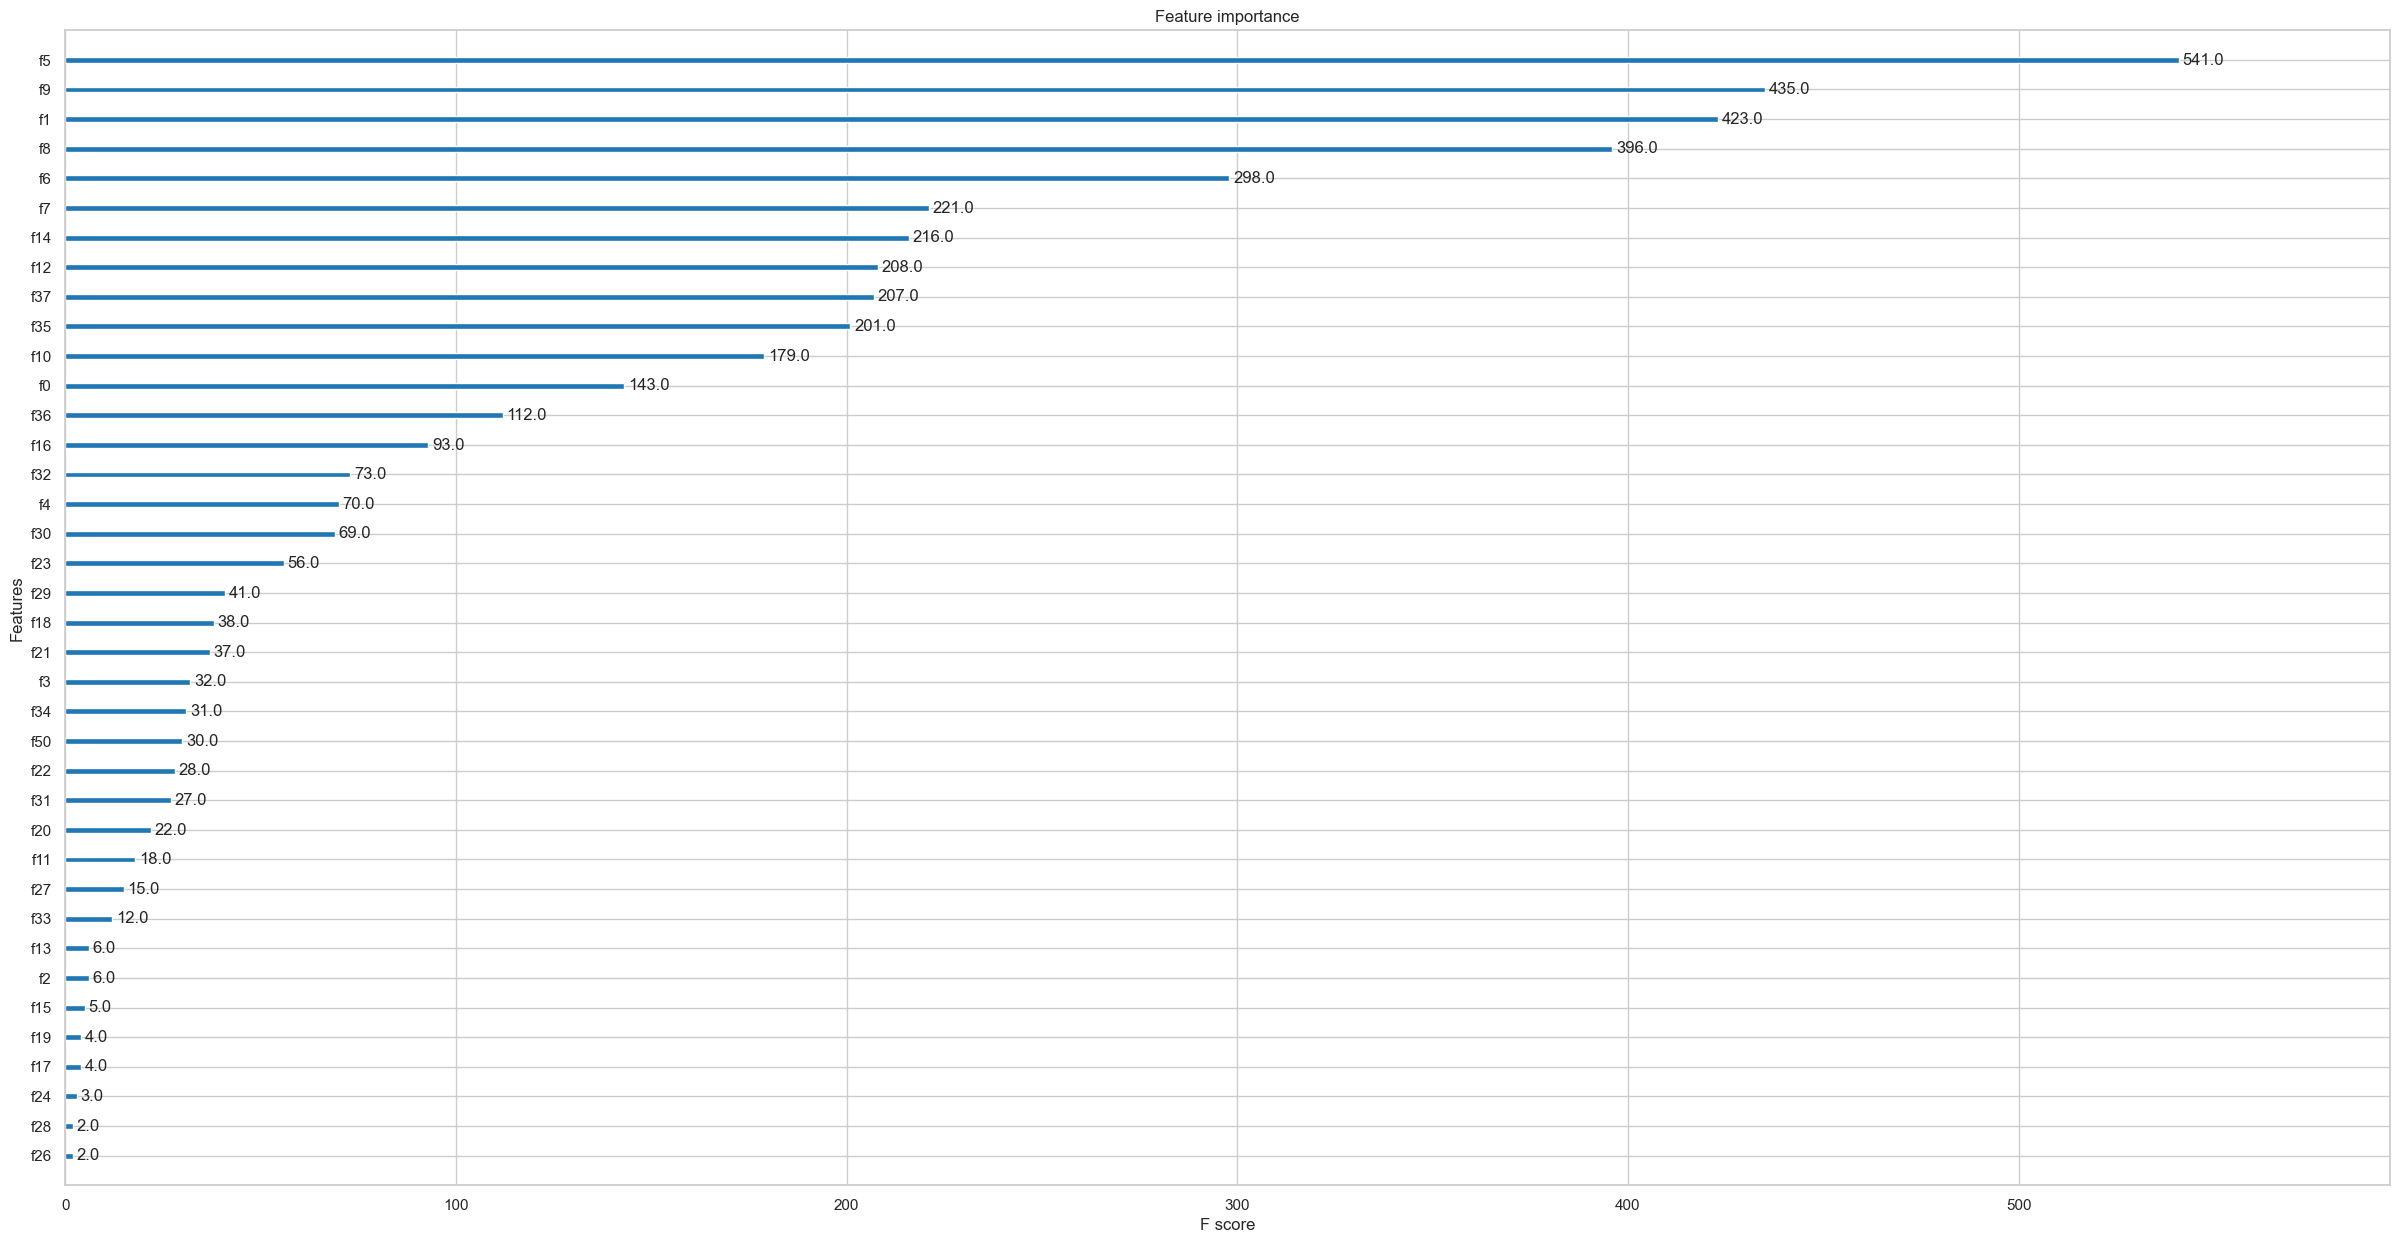

In [151]:
fig, ax = plt.subplots(figsize=(30, 15))

xgb.plot_importance(xgb_final_model, ax=ax)
plt.show()

In [301]:
feature_names_xgb = train_set_extended.drop(['Price_log', 'Price'], axis=1).columns.values
feature_names_xgb = feature_names_xgb[xgb_final_model.feature_importances_.argsort()]

In [302]:
feature_names_xgb = feature_names_xgb[:22]

X_train_set_xgb = train_set_extended[feature_names_xgb]
X_train_set_xgb = xgb_scaler.fit_transform(X_train_set_xgb)

In [192]:
feature_names_xgb

array(['Regionname_Other', 'Rooms_log', 'BuildingArea_log', 'Car_log',
       'Landsize_log', 'prop_count_bkt', 'YearBuilt_log', 'Distance_sqr',
       'Bedroom2_log', 'Landsize_sqr', 'BuildingArea_sqr', 'Bathroom_log',
       'Propertycount_sqr', 'Regionname_Western Metropolitan',
       'Regionname_South-Eastern Metropolitan',
       'Regionname_Northern Metropolitan', 'Bathroom', 'Method_SA',
       'suburb_class', 'Bedroom2', 'Car', 'Resold'], dtype=object)

In [193]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5, 10, 20],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5],
    'max_depth': [3, 6, 10, 15, 20],
    'n_estimators': [50, 100, 300, 500]
}

# Want to be very precise
scoring = ['neg_mean_squared_error']

grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid, 
    scoring=scoring, 
    refit=scoring[0], # in recall before
    n_jobs=-1, 
    cv=3, 
    verbose=0
)

grid_search_xgb = grid_search_xgb.fit(X_train_set_xgb, Y_train_set_xgb)

In [194]:
best_model_xgb = xgb.XGBRegressor(**grid_search_xgb.best_params_).fit(X_train_set_xgb, Y_train_set_xgb)

In [195]:
mean_squared_error(np.exp(best_model_xgb.predict(X_train_set_xgb)), np.exp(Y_train_set_xgb), squared=False)

223900.4168042503

In [299]:
Y_valid_set_xgb = valid_set_extended.Price_log
X_valid_set_xgb = valid_set_extended[feature_names_xgb]

In [303]:
X_valid_set_xgb = xgb_scaler.transform(X_valid_set_xgb)

mean_squared_error(np.exp(best_model_xgb.predict(X_valid_set_xgb)), np.exp(Y_valid_set_xgb), squared=False)

296663.53357895557

- 198566 in train set score, 297286 in valid set score. 18 features
- 223900 in train set score, 296663 in valid set score. 22 features

In [ ]:
X_test_set_xgb = test_set_extended[feature_names_xgb]
X_test_set_xgb = xgb_scaler.transform(X_test_set_xgb)

## Model Creation: Price

### Final Model

We have seen Decision Trees & Random Forests tend to overfit a lot. So we will go to the simple solution we had: Linear Regression (Huber implementation).

In [ ]:
# lr_final_model = Ridge().fit(X_train_set_final, Y_train_set_final)
submission = pd.DataFrame(np.exp(best_model_xgb.predict(X_test_set_xgb)))
submission = submission.reset_index()
submission.columns = ['index', 'Price']
submission.to_csv('Submissions.csv', index=False)
submission